In [305]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
# from dynamic_routing_analysis import decoding_utils , plot_utils
# import dynamic_routing_analysis as dra
import npc_lims

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#test on spontaneous activity
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoder_on_spontaneous_20251219_181131/" #test session
## results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoder_on_spontaneous_20260105_200857/"
## results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoder_on_spontaneous_20260105_202658/"
## results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoder_on_spontaneous_20260105_203404/"
## results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoder_on_spontaneous_1/" 
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoder_on_spontaneous_2/" #all sessions
results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoder_on_spontaneous_10_units_0/" #all sessions, 10 unit min

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/1_5sec_prestim_10_units_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoder_on_spontaneous_10_units_robust_scaler_20260122_212423/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoder_on_spontaneous_10_units_standard_scaler_20260122_212415/"

session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.parquet"
session_table=pl.read_parquet(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')==[],
    pl.col('is_good_behavior').eq(True),
    pl.col('is_engaged').eq(True),
    )['session_id'].to_list()
    )

all_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')==[],
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [307]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'bin_center',
    'electrode_group_names',
    'unit_subsample_size',
    'unit_criteria',
    'labels',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [188]:
### make separate query to include repeats - specify session
sel_session='742903_2024-10-22' #the golden session
# sel_session='670180_2023-07-27' #a templeton session
# sel_session='620263_2022-07-26' #templeton session w/o spontaneous
predict_proba_with_repeats_single_session = (
    pl.scan_parquet(results_path)
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
        pl.col('session_id').eq(sel_session),
    )#.drop('unit_ids') 
    # .sort('session_id', descending=True)
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='inner',
    )
    .with_columns(
        # pl.int_ranges(0, pl.col('predict_proba').list.len()).alias('trial_index')
        pl.col('trial_indices').alias('trial_index')
    )
    .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
    .explode('predict_proba', 'decision_function', 'trial_index',)
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/trials.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            .select('session_id', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response', 'trial_index_in_block', 'block_index', 'stim_start_time',)
        ),
        on=['session_id','trial_index'],
        how='inner',
    ) 
    .group_by('session_id', 'structure', 'unit_subsample_size', 'repeat_idx', 'bin_center', 'unit_ids', 'labels')
    .agg(
        pl.col('balanced_accuracy_test', 'total_n_units').first(),
        pl.col('predict_proba', 'decision_function', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response', 'trial_index_in_block', 'block_index', 'stim_start_time'),
    )
    .sort('session_id','structure', 'unit_subsample_size', 'repeat_idx', 'bin_center')
    # .group_by('session_id','structure')
    .collect()
)


In [189]:
predict_proba_with_repeats_single_session

session_id,structure,unit_subsample_size,repeat_idx,bin_center,unit_ids,labels,balanced_accuracy_test,total_n_units,predict_proba,decision_function,trial_index,is_vis_rewarded,stim_name,is_response,trial_index_in_block,block_index,stim_start_time
str,str,u16,u16,f64,list[str],list[i64],f64,u64,list[f64],list[f64],list[u16],list[bool],list[str],list[bool],list[f64],list[i64],list[f64]
"""742903_2024-10-22""","""ACAd""",10,0,-0.25,"[""742903_2024-10-22_A-333"", ""742903_2024-10-22_A-347"", … ""742903_2024-10-22_A-96""]","[0, 0, … 1]",0.583753,134,"[0.62837, 0.868584, … 0.574251]","[0.525232, 1.888496, … 0.299215]","[0, 1, … 537]","[false, false, … true]","[""sound1"", ""sound1"", … ""sound1""]","[true, true, … true]","[0.0, 1.0, … 88.0]","[0, 0, … 5]","[2521.31188, 2526.94985, … 6147.41574]"
"""742903_2024-10-22""","""ACAd""",10,1,-0.25,"[""742903_2024-10-22_A-103"", ""742903_2024-10-22_A-108"", … ""742903_2024-10-22_A-83""]","[0, 0, … 1]",0.660307,134,"[0.663003, 0.65164, … 0.882046]","[0.676705, 0.626257, … 2.011946]","[0, 1, … 537]","[false, false, … true]","[""sound1"", ""sound1"", … ""sound1""]","[true, true, … true]","[0.0, 1.0, … 88.0]","[0, 0, … 5]","[2521.31188, 2526.94985, … 6147.41574]"
"""742903_2024-10-22""","""ACAd""",10,2,-0.25,"[""742903_2024-10-22_A-100"", ""742903_2024-10-22_A-117"", … ""742903_2024-10-22_A-94""]","[0, 0, … 1]",0.719462,134,"[0.801082, 0.373373, … 0.403989]","[1.39307, -0.517774, … -0.388871]","[0, 1, … 537]","[false, false, … true]","[""sound1"", ""sound1"", … ""sound1""]","[true, true, … true]","[0.0, 1.0, … 88.0]","[0, 0, … 5]","[2521.31188, 2526.94985, … 6147.41574]"
"""742903_2024-10-22""","""ACAd""",10,3,-0.25,"[""742903_2024-10-22_A-108"", ""742903_2024-10-22_A-117"", … ""742903_2024-10-22_A-96""]","[0, 0, … 1]",0.710063,134,"[0.825487, 0.205554, … 0.868513]","[1.553971, -1.351939, … 1.887873]","[0, 1, … 537]","[false, false, … true]","[""sound1"", ""sound1"", … ""sound1""]","[true, true, … true]","[0.0, 1.0, … 88.0]","[0, 0, … 5]","[2521.31188, 2526.94985, … 6147.41574]"
"""742903_2024-10-22""","""ACAd""",10,4,-0.25,"[""742903_2024-10-22_A-106"", ""742903_2024-10-22_A-117"", … ""742903_2024-10-22_A-96""]","[0, 0, … 1]",0.724913,134,"[0.82041, 0.654559, … 0.476467]","[1.51913, 0.639138, … -0.0942]","[0, 1, … 537]","[false, false, … true]","[""sound1"", ""sound1"", … ""sound1""]","[true, true, … true]","[0.0, 1.0, … 88.0]","[0, 0, … 5]","[2521.31188, 2526.94985, … 6147.41574]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""742903_2024-10-22""","""TTd""",10,20,-0.25,"[""742903_2024-10-22_E-1213"", ""742903_2024-10-22_E-32"", … ""742903_2024-10-22_E-994""]","[0, 0, … 1]",0.509364,240,"[0.350867, 0.377819, … 0.570371]","[-0.615229, -0.498815, … 0.283366]","[0, 1, … 537]","[false, false, … true]","[""sound1"", ""sound1"", … ""sound1""]","[true, true, … true]","[0.0, 1.0, … 88.0]","[0, 0, … 5]","[2521.31188, 2526.94985, … 6147.41574]"
"""742903_2024-10-22""","""TTd""",10,21,-0.25,"[""742903_2024-10-22_E-1006"", ""742903_2024-10-22_E-1213"", … ""742903_2024-10-22_F-0""]","[0, 0, … 1]",0.509539,240,"[0.479048, 0.493378, … 0.543007]","[-0.083855, -0.026489, … 0.172453]","[0, 1, … 537]","[false, false, … true]","[""sound1"", ""sound1"", … ""sound1""]","[true, true, … true]","[0.0, 1.0, … 88.0]","[0, 0, … 5]","[2521.31188, 2526.94985, … 6147.41574]"
"""742903_2024-10-22""","""TTd""",10,22,-0.25,"[""742903_2024-10-22_E-1"", ""742903_2024-10-22_E-1007"", … ""742903_2024-10-22_E-85""]","[0, 0, … 1]",0.537142,240,"[0.376537, 0.424026, … 0.392966]","[-0.504273, -0.306267, … -0.434863]","[0, 1, … 537]","[false, false, … true]","[""sound1"", ""sound1"", … ""sound1""]","[true, true, … true]","[0.0, 1.0, … 88.0]","[0, 0, … 5]","[2521.31188, 2526.94985, … 6147.41574]"


In [190]:
### spontaneous activity results

predict_proba_with_repeats_single_session_spontaneous = (
    pl.scan_parquet(results_path)
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
        pl.col('session_id').eq(sel_session),
    )#.drop('unit_ids') 
    # .sort('session_id', descending=True)
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='inner',
    )
    .with_columns(
        pl.int_ranges(0, pl.col('predict_proba_spont').list.len()).alias('trial_index')
        # pl.col('trial_indices').alias('trial_index')
    )
    .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
    .explode('predict_proba_spont', 'decision_function_spont', 'pred_label_spont','spont_trial_times','spont_epoch_name','spont_trial_is_rewarded','trial_index',)
    .group_by('session_id', 'structure', 'unit_subsample_size', 'repeat_idx', 'bin_center', 'unit_ids', 'labels')
    .agg(
        pl.col('balanced_accuracy_test', 'total_n_units').first(),
        pl.col('predict_proba_spont', 'decision_function_spont', 'trial_index', 'pred_label_spont','spont_trial_times','spont_epoch_name','spont_trial_is_rewarded'),
    )
    .sort('session_id','structure', 'unit_subsample_size', 'repeat_idx', 'bin_center')
    # .group_by('session_id','structure')
    .collect()
)

In [191]:
predict_proba_with_repeats_single_session_spontaneous

session_id,structure,unit_subsample_size,repeat_idx,bin_center,unit_ids,labels,balanced_accuracy_test,total_n_units,predict_proba_spont,decision_function_spont,trial_index,pred_label_spont,spont_trial_times,spont_epoch_name,spont_trial_is_rewarded
str,str,u16,u16,f64,list[str],list[i64],f64,u64,list[f64],list[f64],list[i64],list[str],list[f64],list[str],list[bool]
"""742903_2024-10-22""","""ACAd""",10,0,-0.25,"[""742903_2024-10-22_A-333"", ""742903_2024-10-22_A-347"", … ""742903_2024-10-22_A-96""]","[0, 0, … 1]",0.583753,134,"[0.438001, 0.446471, … 0.534709]","[-0.24928, -0.214941, … 0.13906]","[0, 1, … 361]","[""aud"", ""aud"", … ""vis""]","[1295.04894, 1300.615607, … 7382.18208]","[""Spontaneous"", ""Spontaneous"", … ""Spontaneous""]","[false, false, … false]"
"""742903_2024-10-22""","""ACAd""",10,1,-0.25,"[""742903_2024-10-22_A-103"", ""742903_2024-10-22_A-108"", … ""742903_2024-10-22_A-83""]","[0, 0, … 1]",0.660307,134,"[0.538987, 0.538987, … 0.586141]","[0.156267, 0.156267, … 0.348033]","[0, 1, … 361]","[""vis"", ""vis"", … ""vis""]","[1295.04894, 1300.615607, … 7382.18208]","[""Spontaneous"", ""Spontaneous"", … ""Spontaneous""]","[false, false, … false]"
"""742903_2024-10-22""","""ACAd""",10,2,-0.25,"[""742903_2024-10-22_A-100"", ""742903_2024-10-22_A-117"", … ""742903_2024-10-22_A-94""]","[0, 0, … 1]",0.719462,134,"[0.204158, 0.235372, … 0.396287]","[-1.360505, -1.17822, … -0.420959]","[0, 1, … 361]","[""aud"", ""aud"", … ""aud""]","[1295.04894, 1300.615607, … 7382.18208]","[""Spontaneous"", ""Spontaneous"", … ""Spontaneous""]","[false, false, … false]"
"""742903_2024-10-22""","""ACAd""",10,3,-0.25,"[""742903_2024-10-22_A-108"", ""742903_2024-10-22_A-117"", … ""742903_2024-10-22_A-96""]","[0, 0, … 1]",0.710063,134,"[0.401264, 0.388586, … 0.369412]","[-0.400202, -0.45326, … -0.534739]","[0, 1, … 361]","[""aud"", ""aud"", … ""aud""]","[1295.04894, 1300.615607, … 7382.18208]","[""Spontaneous"", ""Spontaneous"", … ""Spontaneous""]","[false, false, … false]"
"""742903_2024-10-22""","""ACAd""",10,4,-0.25,"[""742903_2024-10-22_A-106"", ""742903_2024-10-22_A-117"", … ""742903_2024-10-22_A-96""]","[0, 0, … 1]",0.724913,134,"[0.121553, 0.172391, … 0.421806]","[-1.97781, -1.568774, … -0.315363]","[0, 1, … 361]","[""aud"", ""aud"", … ""aud""]","[1295.04894, 1300.615607, … 7382.18208]","[""Spontaneous"", ""Spontaneous"", … ""Spontaneous""]","[false, false, … false]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""742903_2024-10-22""","""TTd""",10,20,-0.25,"[""742903_2024-10-22_E-1213"", ""742903_2024-10-22_E-32"", … ""742903_2024-10-22_E-994""]","[0, 0, … 1]",0.509364,240,"[0.574273, 0.38566, … 0.668006]","[0.299307, -0.46559, … 0.699182]","[0, 1, … 361]","[""vis"", ""aud"", … ""vis""]","[1295.04894, 1300.615607, … 7382.18208]","[""Spontaneous"", ""Spontaneous"", … ""Spontaneous""]","[false, false, … false]"
"""742903_2024-10-22""","""TTd""",10,21,-0.25,"[""742903_2024-10-22_E-1006"", ""742903_2024-10-22_E-1213"", … ""742903_2024-10-22_F-0""]","[0, 0, … 1]",0.509539,240,"[0.507927, 0.477355, … 0.499812]","[0.03171, -0.090644, … -0.000754]","[0, 1, … 361]","[""vis"", ""aud"", … ""aud""]","[1295.04894, 1300.615607, … 7382.18208]","[""Spontaneous"", ""Spontaneous"", … ""Spontaneous""]","[false, false, … false]"
"""742903_2024-10-22""","""TTd""",10,22,-0.25,"[""742903_2024-10-22_E-1"", ""742903_2024-10-22_E-1007"", … ""742903_2024-10-22_E-85""]","[0, 0, … 1]",0.537142,240,"[0.530407, 0.474233, … 0.503096]","[0.12178, -0.103158, … 0.012383]","[0, 1, … 361]","[""vis"", ""aud"", … ""vis""]","[1295.04894, 1300.615607, … 7382.18208]","[""Spontaneous"", ""Spontaneous"", … ""Spontaneous""]","[false, false, … false]"


In [192]:
predict_proba_single_session_pd=predict_proba_with_repeats_single_session.to_pandas()
predict_proba_with_repeats_single_session_spontaneous_pd=predict_proba_with_repeats_single_session_spontaneous.to_pandas()

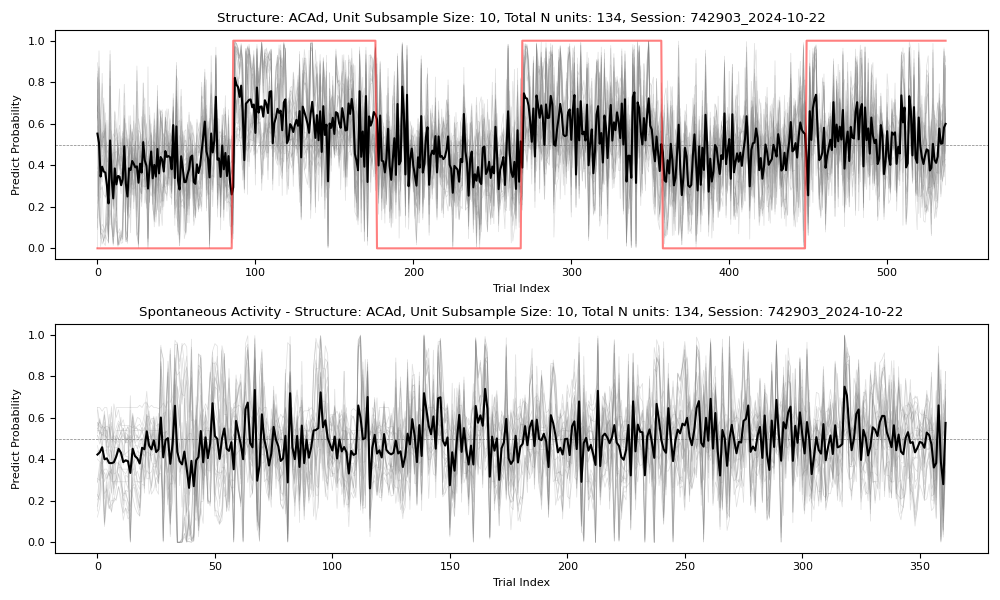

In [195]:
# show individual repeats, averages over repeats, etc.
sel_bin_center=-0.25
sel_structure='ACAd'
sel_unit_subsample=10
if sel_unit_subsample is None or sel_unit_subsample == 'all':
    structure_predict_proba=predict_proba_single_session_pd.query('structure==@sel_structure and unit_subsample_size.isna() and bin_center==@sel_bin_center')
    structure_predict_proba_spont=predict_proba_with_repeats_single_session_spontaneous_pd.query('structure==@sel_structure and unit_subsample_size.isna() and bin_center==@sel_bin_center')
else:
    structure_predict_proba=predict_proba_single_session_pd.query('structure==@sel_structure and unit_subsample_size==@sel_unit_subsample and bin_center==@sel_bin_center')
    structure_predict_proba_spont=predict_proba_with_repeats_single_session_spontaneous_pd.query('structure==@sel_structure and unit_subsample_size==@sel_unit_subsample and bin_center==@sel_bin_center')

trial_index=structure_predict_proba['trial_index'].iloc[0]
total_n_units=structure_predict_proba['total_n_units'].iloc[0]

trial_index_spont=structure_predict_proba_spont['trial_index'].iloc[0]

spont_is_rewarded=structure_predict_proba_spont['spont_trial_is_rewarded'].iloc[0]

epoch_names=structure_predict_proba_spont['spont_epoch_name'].iloc[0]

fig,ax=plt.subplots(2,1,figsize=(10,6),sharey=True)
ax[0].axhline(0.5, color='grey', linestyle='--', linewidth=0.5)
ax[0].plot(trial_index, np.vstack(structure_predict_proba['predict_proba'].values).T, color='grey', alpha=0.25, linewidth=0.5)
ax[0].plot(trial_index, np.mean(np.vstack(structure_predict_proba['predict_proba'].values),0), color='black')
ax[0].plot(trial_index, structure_predict_proba['labels'].values[0], color='red', alpha=0.5, label='true label')
ax[0].set_xlabel('Trial Index')
ax[0].set_ylabel('Predict Probability')
ax[0].set_title(f'Structure: {sel_structure}, Unit Subsample Size: {sel_unit_subsample}, Total N units: {total_n_units}, Session: {sel_session}')

ax[1].axhline(0.5, color='grey', linestyle='--', linewidth=0.5)
ax[1].plot(trial_index_spont, np.vstack(structure_predict_proba_spont['predict_proba_spont'].values).T, color='grey', alpha=0.25, linewidth=0.5)
ax[1].plot(trial_index_spont, np.mean(np.vstack(structure_predict_proba_spont['predict_proba_spont'].values),0), color='black')
# ax[1].plot(np.where(spont_is_rewarded)[0], structure_predict_proba_spont['predict_proba_spont'].values[0][spont_is_rewarded],
#            marker='o',color='blue', linestyle='')
# ax[1].plot(trial_index_spont, structure_predict_proba_spont['labels'].values[0], color='red', alpha=0.5, label='true label')
ax[1].set_xlabel('Trial Index')
ax[1].set_ylabel('Predict Probability')
ax[1].set_title(f'Spontaneous Activity - Structure: {sel_structure}, Unit Subsample Size: {sel_unit_subsample}, Total N units: {total_n_units}, Session: {sel_session}')

fig.tight_layout()


In [196]:
#get epochs
session_id=sel_session
epochs=pd.read_parquet(
    npc_lims.get_cache_path('epochs',session_id,version='any')
)
epochs

,start_time,stop_time,script_name,notes,interval_names,tags,session_idx,date,subject_id,session_id
id,,,,,,,,,,
0,44.79145,915.504433,RFMapping,,"[vis_rf_mapping_trials, aud_rf_mapping_trials]",[mapping],0,2024-10-22,742903,742903_2024-10-22
1,925.76399,1276.573301,OptoTagging,,[optotagging_trials],[optotagging],0,2024-10-22,742903,742903_2024-10-22
2,1286.79894,1889.936699,Spontaneous,,[spontaneous_trials],[spontaneous],0,2024-10-22,742903,742903_2024-10-22
3,1900.72890,2503.800740,SpontaneousRewards,,[spontaneous_rewards_trials],"[rewards, spontaneous]",0,2024-10-22,742903,742903_2024-10-22
4,2514.35961,6155.325601,DynamicRouting1,,"[trials, performance]","[task, rewards]",0,2024-10-22,742903,742903_2024-10-22
5,6166.13478,6769.256588,SpontaneousRewards,,[spontaneous_rewards_trials],"[rewards, spontaneous]",0,2024-10-22,742903,742903_2024-10-22
6,6779.73208,7382.853794,Spontaneous,,[spontaneous_trials],[spontaneous],0,2024-10-22,742903,742903_2024-10-22
7,7393.26257,7741.754331,OptoTagging,,[optotagging_trials],[optotagging],0,2024-10-22,742903,742903_2024-10-22


In [197]:
predict_proba_single_session_pd['structure'].unique()

array(['ACAd', 'ACAv', 'CP', 'GU', 'ILA', 'LSr', 'MOs', 'ORBl', 'ORBm',
       'ORBvl', 'PL', 'SSp', 'SSs', 'TTd'], dtype=object)

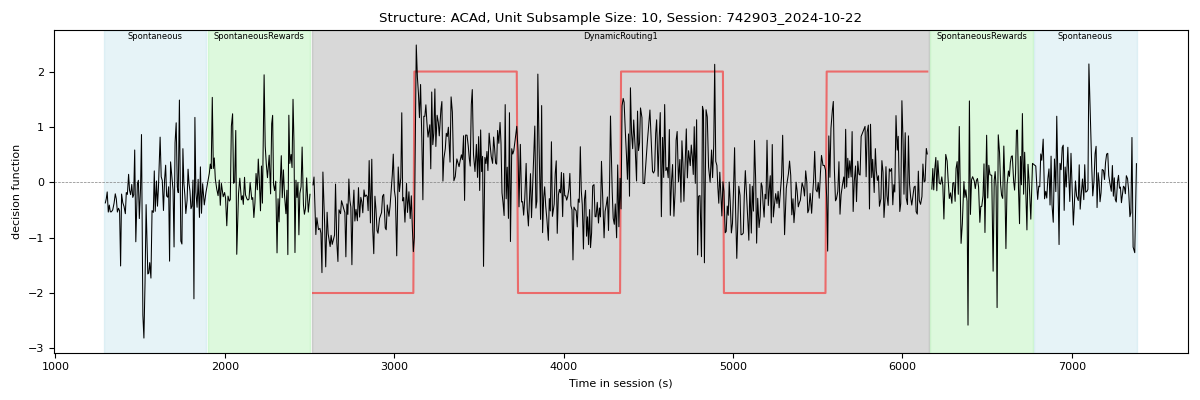

In [ ]:
#plot predict proba across epochs, shade epochs
sel_structure='ACAd'
plot_data_string='decision_function' # 'decision_function' or 'predict_proba'
sel_unit_subsample=10
if sel_unit_subsample is None or sel_unit_subsample == 'all':
    structure_predict_proba=predict_proba_single_session_pd.query('structure==@sel_structure and unit_subsample_size.isna() and bin_center==@sel_bin_center')
    structure_predict_proba_spont=predict_proba_with_repeats_single_session_spontaneous_pd.query('structure==@sel_structure and unit_subsample_size.isna() and bin_center==@sel_bin_center')
else:
    structure_predict_proba=predict_proba_single_session_pd.query('structure==@sel_structure and unit_subsample_size==@sel_unit_subsample and bin_center==@sel_bin_center')
    structure_predict_proba_spont=predict_proba_with_repeats_single_session_spontaneous_pd.query('structure==@sel_structure and unit_subsample_size==@sel_unit_subsample and bin_center==@sel_bin_center')

trial_times=structure_predict_proba['stim_start_time'].iloc[0]
total_n_units=structure_predict_proba['total_n_units'].iloc[0]

trial_times_spont=structure_predict_proba_spont['spont_trial_times'].iloc[0]

pretask_spont_index=trial_times_spont<trial_times[0]

fig,ax=plt.subplots(figsize=(12,4))
if plot_data_string=='predict_proba':
    ax.axhline(0.5, color='grey', linestyle='--', linewidth=0.5)
    ax.plot(trial_times, structure_predict_proba['labels'].values[0], color='red', alpha=0.5, label='true label')
    ax.set_ylabel('p(vis context)')
elif plot_data_string=='decision_function':
    ax.axhline(0.0, color='grey', linestyle='--', linewidth=0.5)
    ax.plot(trial_times, structure_predict_proba['labels'].values[0]*4-2, color='red', alpha=0.5, label='true label')
    ax.set_ylabel('decision function')

ax.plot(trial_times, np.mean(np.vstack(structure_predict_proba[plot_data_string].values),0), color='black', label='task trials', linewidth=0.75)
ax.plot(trial_times_spont[pretask_spont_index], 
        np.mean(np.vstack(structure_predict_proba_spont[f'{plot_data_string}_spont'].values),0)[pretask_spont_index], 
        color='black', label='pre-task spontaneous', linewidth=0.75)
ax.plot(trial_times_spont[~pretask_spont_index], 
np.mean(np.vstack(structure_predict_proba_spont[f'{plot_data_string}_spont'].values),0)[~pretask_spont_index], 
        color='black', label='post-task spontaneous', linewidth=0.75)

ax.set_xlabel('Time in session (s)')

ax.set_title(f'Structure: {sel_structure}, Unit Subsample Size: {sel_unit_subsample}, Session: {sel_session}')
# ax.legend()

#add patches for Spontaneous, SpontaneousRewards, DynamicRouting1 epochs
for _,epoch_row in epochs.iterrows():
    epoch_start=epoch_row['start_time']
    epoch_end=epoch_row['stop_time']
    epoch_name=epoch_row['script_name']
    if epoch_name=='Spontaneous':
        color='lightblue'
    elif epoch_name=='SpontaneousRewards':
        color='lightgreen'
    elif epoch_name=='DynamicRouting1':
        color='grey'
    else:
        continue
    ax.axvspan(epoch_start, epoch_end, color=color, alpha=0.3, label=epoch_name)
    ymin, ymax = ax.get_ylim()
    ax.text((epoch_start+epoch_end)/2, ymax*0.99, epoch_name, ha='center', va='top', fontsize=6,)

    
fig.tight_layout()

In [ ]:
r,p=stats.pearsonr(np.mean(np.vstack(structure_predict_proba['decision_function'].values),0),np.mean(np.vstack(structure_predict_proba['predict_proba'].values),0))
r

In [ ]:
fig,ax=plt.subplots(figsize=(8,3))
norm_predict_proba=np.mean(np.vstack(structure_predict_proba['predict_proba'].values),0)-0.5
# norm_predict_proba=(norm_predict_proba-min(norm_predict_proba))
# norm_predict_proba=norm_predict_proba/(max(np.abs(norm_predict_proba)))
norm_predict_proba=norm_predict_proba/np.std(norm_predict_proba)

norm_decision_function=np.mean(np.vstack(structure_predict_proba['decision_function'].values),0)
# norm_decision_function=(norm_decision_function-min(norm_decision_function))
# norm_decision_function=norm_decision_function/(max(np.abs(norm_decision_function)))
norm_decision_function=norm_decision_function/np.std(norm_decision_function)

ax.axhline(0.0, color='grey', linestyle='--', linewidth=0.5)
ax.plot(trial_times, norm_predict_proba, color='tab:blue', label='predict proba',linewidth=0.75,alpha=0.75)
ax.plot(trial_times, norm_decision_function, color='tab:orange', label='decision function',linewidth=0.75,alpha=0.75)
ax.set_xlabel('Time in session (s)')
ax.set_ylabel('Normalized Value')
ax.set_title(f'Structure: {sel_structure}, Unit Subsample Size: {sel_unit_subsample}, Session: {sel_session}, r={r:.3f}, p={p:.2e}')
ax.legend()

fig.tight_layout()

In [15]:
#subtract blockwise means
def subtract_blockwise_mean(input, block_indices):
    adjusted_input = np.zeros_like(input)
    unique_blocks = np.unique(block_indices)
    for block in unique_blocks:
        block_mask = (block_indices == block)
        block_mean = np.mean(input[block_mask])
        adjusted_input[block_mask] = input[block_mask] - block_mean
    return adjusted_input

#flip aud blocks
def flip_auditory_blocks(input, block_indices, is_vis_rewarded, input_type=None):
    adjusted_input = input.copy()
    unique_blocks = np.unique(block_indices)
    for block in unique_blocks:
        block_mask = (block_indices == block)
        if input_type=='predict_proba':
            if not is_vis_rewarded[block_mask].all():
                adjusted_input[block_mask] = 1.0 - input[block_mask]
        elif input_type=='decision_function':
            if not is_vis_rewarded[block_mask].all():
                adjusted_input[block_mask] = -input[block_mask]
        else:
            print('ERROR: must provide input type: predict_proba or decision_function')
            raise NotImplementedError
    return adjusted_input

#exclude is instruction
def exclude_instruction_trials(input, is_instruction_trial):
    adjusted_input = input.copy()
    adjusted_input[is_instruction_trial] = np.nan
    return adjusted_input



In [ ]:
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/performance.parquet').collect().to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/trials.parquet').collect().to_pandas()

In [ ]:
#correlate each epoch's predict proba across areas
sel_structure_1='ACAd'
sel_structure_2='ORBl'

session_trials=all_trials.query('session_id==@sel_session')

plot_data_string='predict_proba' # 'decision_function' or 'predict_proba'
sel_unit_subsample=20
if sel_unit_subsample is None or sel_unit_subsample == 'all':
    structure_predict_proba_1=predict_proba_single_session_pd.query('structure==@sel_structure_1 and unit_subsample_size.isna() and bin_center==@sel_bin_center')['predict_proba'].mean()
    structure_predict_proba_spont_1=predict_proba_with_repeats_single_session_spontaneous_pd.query('structure==@sel_structure_1 and unit_subsample_size.isna() and bin_center==@sel_bin_center')['predict_proba_spont'].mean()
    structure_predict_proba_2=predict_proba_single_session_pd.query('structure==@sel_structure_2 and unit_subsample_size.isna() and bin_center==@sel_bin_center')['predict_proba'].mean()
    structure_predict_proba_spont_2=predict_proba_with_repeats_single_session_spontaneous_pd.query('structure==@sel_structure_2 and unit_subsample_size.isna() and bin_center==@sel_bin_center')['predict_proba_spont'].mean()
else:
    structure_predict_proba_1=predict_proba_single_session_pd.query('structure==@sel_structure_1 and unit_subsample_size==@sel_unit_subsample and bin_center==@sel_bin_center')['predict_proba'].mean()
    structure_predict_proba_spont_1=predict_proba_with_repeats_single_session_spontaneous_pd.query('structure==@sel_structure_1 and unit_subsample_size==@sel_unit_subsample and bin_center==@sel_bin_center')['predict_proba_spont'].mean()
    structure_predict_proba_2=predict_proba_single_session_pd.query('structure==@sel_structure_2 and unit_subsample_size==@sel_unit_subsample and bin_center==@sel_bin_center')['predict_proba'].mean()
    structure_predict_proba_spont_2=predict_proba_with_repeats_single_session_spontaneous_pd.query('structure==@sel_structure_2 and unit_subsample_size==@sel_unit_subsample and bin_center==@sel_bin_center')['predict_proba_spont'].mean()

task_block_indices=predict_proba_single_session_pd['block_index'].iloc[0]
task_is_vis_rewarded=predict_proba_single_session_pd['is_vis_rewarded'].iloc[0]
task_is_instruction=session_trials['is_instruction'].values


#get spontaneous blocks
spont_times=predict_proba_with_repeats_single_session_spontaneous_pd['spont_trial_times'].iloc[0]
spont_epoch_names=predict_proba_with_repeats_single_session_spontaneous_pd['spont_epoch_name'].iloc[0]
spont_block_indices=[0]
spont_block=0
for tt in range(1,len(spont_times)):
    if spont_epoch_names[tt]!=spont_epoch_names[tt-1]:
        spont_block+=1
    elif spont_times[tt]-spont_times[tt-1]>60.0: #if gap >60s, new block
        spont_block+=1
    spont_block_indices.append(spont_block)

adj_pred_proba_1 = exclude_instruction_trials(flip_auditory_blocks(structure_predict_proba_1, task_block_indices, task_is_vis_rewarded), task_is_instruction)
adj_pred_proba_2 = exclude_instruction_trials(flip_auditory_blocks(structure_predict_proba_2, task_block_indices, task_is_vis_rewarded), task_is_instruction)
adj_pred_proba_spont_1 = subtract_blockwise_mean(structure_predict_proba_spont_1, np.array(spont_block_indices))
adj_pred_proba_spont_2 = subtract_blockwise_mean(structure_predict_proba_spont_2, np.array(spont_block_indices))


fig,ax=plt.subplots(2,1,figsize=(8,6))
#task trials
ax[0].plot(adj_pred_proba_1, alpha=0.75, label=sel_structure_1, linewidth=0.75)
ax[0].plot(adj_pred_proba_2, alpha=0.75, label=sel_structure_2, linewidth=0.75)
r_task,p_task=stats.pearsonr(adj_pred_proba_1[~np.isnan(adj_pred_proba_1)], adj_pred_proba_2[~np.isnan(adj_pred_proba_1)])
ax[0].set_title(f'Task Trials: r={r_task:.3f}, p={p_task:.2e}')
ax[0].legend()
#spontaneous trials
ax[1].plot(adj_pred_proba_spont_1, alpha=0.75, label=sel_structure_1, linewidth=0.75)
ax[1].plot(adj_pred_proba_spont_2, alpha=0.75, label=sel_structure_2, linewidth=0.75)
r_spont,p_spont=stats.pearsonr(adj_pred_proba_spont_1[~np.isnan(adj_pred_proba_spont_1)], adj_pred_proba_spont_2[~np.isnan(adj_pred_proba_spont_1)])
ax[1].set_title(f'Spontaneous Trials: r={r_spont:.3f}, p={p_spont:.2e}')
ax[1].legend()

In [308]:
#grab task results from all sessions

structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

predict_proba_pd = (
    pl.scan_parquet(results_path,extra_columns='ignore')
    #make new column that indicates whether a row is the sole recording from a structure in a session
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
    )
    #Grab only rows according to combine_multi_probe_rec toggle
    #Grab only rows that have is_all_trials == True, only these have predict_proba
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
    )
    # #join on the units table to get total number of units per structure
    # .join(
    #     other=(
    #         pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/units.parquet')
    #         .with_columns(
    #             pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
    #         )
    #         #make new rows according to structure_grouping
    #         .with_columns(
    #             pl.when(pl.col('structure').is_in(structure_grouping.keys()))
    #             .then(pl.col('structure').repeat_by(n_repeats))
    #             .otherwise(pl.col('structure').repeat_by(1))
    #         )
    #         .explode('structure')
    #         .with_columns(
    #             pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
    #             .then(pl.col('structure').replace(structure_grouping))
    #             .otherwise(pl.col('structure'))
    #         )
    #         .group_by('session_id','structure')
    #         .agg(
    #             pl.col('unit_id').len().alias('total_n_units')
    #         )
    #     ),
    #     on=['session_id','structure'],
    #     how='left',
    # )
    .with_columns(
        # pl.int_ranges(0, pl.col('predict_proba').list.len()).alias('trial_index')
        pl.col('trial_indices').alias('trial_index')
    )
    .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording', 'unit_ids')
    .explode('predict_proba', 'decision_function', 'trial_index')
    .group_by('session_id', 'structure', 'unit_subsample_size', 'trial_index', 'bin_center', 'bin_size', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').mean(),
        pl.col('predict_proba').mean(),
        pl.col('decision_function').mean(),
        # pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
    )
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/trials.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
                #iti column?
            )
            .select('session_id', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response')
        ),
        on=['session_id','trial_index'],
        how='inner',
    ) 
    .group_by('session_id', 'structure', 'unit_subsample_size', 'bin_center', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').first(),
        # pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
        pl.col('predict_proba', 'decision_function', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response').sort_by('trial_index'),

    )
    .sort('session_id','structure', 'unit_subsample_size', 'bin_center')
    # .group_by('session_id','structure')
    .collect(engine='streaming')
).to_pandas()

In [ ]:
# len(pl.scan_parquet(results_path,extra_columns='ignore').columns)

In [9]:
#grab spont results from all sessions

# sel_session='742903_2024-10-22'
# 
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

predict_proba_spont_pd = (
    pl.scan_parquet(results_path)
    #make new column that indicates whether a row is the sole recording from a structure in a session
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
    )
    #Grab only rows according to combine_multi_probe_rec toggle
    #Grab only rows that have is_all_trials == True, only these have predict_proba
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
        # pl.col('session_id').eq(sel_session)
    )
    
    .with_columns(
        pl.int_ranges(0, pl.col('predict_proba_spont').list.len()).alias('trial_index')
    )
    .drop(
        'shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording', 
        'predict_proba', 'predict_proba_all_trials', 'decision_function', 'decision_function_all',
        'balanced_accuracy_test','balanced_accuracy_train','unit_ids','coefs', 'trial_indices'  
    )
    
    .explode('predict_proba_spont', 'decision_function_spont', 'trial_index',)
    .group_by('session_id', 'structure', 'unit_subsample_size', 'bin_center', 'bin_size', 'time_aligned_to', 'trial_index', )
    .agg(
        pl.col('predict_proba_spont').mean(),
        pl.col('decision_function_spont').mean(),
        pl.col('spont_trial_times').first(),
        pl.col('spont_epoch_name').first(),
        pl.col('spont_trial_is_rewarded').first(),
        # pl.col('pred_label_spont').eq('vis').mean(),
        # pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
    )
    .group_by('session_id', 'structure', 'unit_subsample_size', 'bin_center', 'bin_size', 'time_aligned_to',)
    .agg(
        # pl.col('balanced_accuracy_test').first(),
        # pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
        pl.col('spont_trial_times').first(),
        pl.col('spont_epoch_name').first(),
        pl.col('spont_trial_is_rewarded').first(),
        pl.col('predict_proba_spont', 'decision_function_spont', 'trial_index').sort_by('trial_index'),

    )
    .sort('session_id','structure', 'unit_subsample_size', 'bin_center', 'bin_size', 'time_aligned_to',)
    .collect(engine='streaming')
).to_pandas()

In [ ]:
# predict_proba_pd=predict_proba_wo_repeats.to_pandas()
# predict_proba_spont_pd=predict_proba_spont_wo_repeats.to_pandas()
# pl.scan_parquet(results_path).columns

In [ ]:
# savepath=r'D:\decoding_results_from_CO\task_vs_spont_2026-01-06\task_predict_proba_by_session_10_units.parquet'
# savepath=r'D:\decoding_results_from_CO\prestim_only_1_5sec_10_units_2026-01-26\task_predict_proba_by_session_10_units.parquet'
# predict_proba_pd.to_parquet(savepath)

# savepath=r'D:\decoding_results_from_CO\task_vs_spont_2026-01-06\spont_predict_proba_by_session_10_units.parquet'
# predict_proba_spont_pd.to_parquet(savepath)

In [310]:
#load from saved files
loadpath=r'D:\decoding_results_from_CO\task_vs_spont_2026-01-06\task_predict_proba_by_session_10_units.parquet'
predict_proba_pd=pd.read_parquet(loadpath)

loadpath=r'D:\decoding_results_from_CO\task_vs_spont_2026-01-06\spont_predict_proba_by_session_10_units.parquet'
predict_proba_spont_pd=pd.read_parquet(loadpath)

In [5]:
predict_proba_spont_pd

,session_id,structure,unit_subsample_size,bin_center,bin_size,time_aligned_to,spont_trial_times,spont_epoch_name,spont_trial_is_rewarded,predict_proba_spont,decision_function_spont,trial_index
0,660023_2023-08-09,CA1,10,-0.25,0.5,stim_start_time,"[15050.908263333333, 15056.474929999998, 15062...","[Spontaneous, Spontaneous, Spontaneous, Sponta...","[False, False, False, False, False, False, Fal...","[0.5793412497626123, 0.5904740411255041, 0.486...","[0.35348742352527396, 0.41589491118921473, -0....","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,660023_2023-08-09,DG,10,-0.25,0.5,stim_start_time,"[15050.908263333333, 15056.474929999998, 15062...","[Spontaneous, Spontaneous, Spontaneous, Sponta...","[False, False, False, False, False, False, Fal...","[0.7300829516604544, 0.5778750028376232, 0.732...","[1.821350757207245, 0.4597994064101097, 1.3014...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,660023_2023-08-09,LP,10,-0.25,0.5,stim_start_time,"[15050.908263333333, 15056.474929999998, 15062...","[Spontaneous, Spontaneous, Spontaneous, Sponta...","[False, False, False, False, False, False, Fal...","[0.5091017328371156, 0.478771434076959, 0.4444...","[0.44056155296839333, -0.1852835155543253, 0.2...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,660023_2023-08-09,MB,10,-0.25,0.5,stim_start_time,"[15050.908263333333, 15056.474929999998, 15062...","[Spontaneous, Spontaneous, Spontaneous, Sponta...","[False, False, False, False, False, False, Fal...","[0.5591449980591563, 0.4732934478051912, 0.585...","[0.7473290317257028, -0.3071325212037605, 0.50...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,660023_2023-08-09,MOp,10,-0.25,0.5,stim_start_time,"[15050.908263333333, 15056.474929999998, 15062...","[Spontaneous, Spontaneous, Spontaneous, Sponta...","[False, False, False, False, False, False, Fal...","[0.742749478997946, 0.6617647457816017, 0.6061...","[1.346447581648959, 0.9898603159318098, 0.5091...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1906,761583_2024-12-17,LD,10,-0.25,0.5,stim_start_time,"[931.5858000000001, 937.8191333333333, 944.385...","[Spontaneous, Spontaneous, Spontaneous, Sponta...","[False, False, False, False, False, False, Fal...","[0.5399073073435928, 0.5280795129445965, 0.585...","[0.16006180181822866, 0.11256748110183828, 0.3...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1907,761583_2024-12-17,LP,10,-0.25,0.5,stim_start_time,"[931.5858000000001, 937.8191333333333, 944.385...","[Spontaneous, Spontaneous, Spontaneous, Sponta...","[False, False, False, False, False, False, Fal...","[0.4971547584723443, 0.5411519313367397, 0.421...","[-0.011507400717735518, 0.16590820707872783, -...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1908,761583_2024-12-17,PO,10,-0.25,0.5,stim_start_time,"[931.5858000000001, 937.8191333333333, 944.385...","[Spontaneous, Spontaneous, Spontaneous, Sponta...","[False, False, False, False, False, False, Fal...","[0.5744618310988527, 0.5740269192839506, 0.552...","[0.3005469979016384, 0.29887090630584046, 0.21...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1909,761583_2024-12-17,SSp,10,-0.25,0.5,stim_start_time,"[931.5858000000001, 937.8191333333333, 944.385...","[Spontaneous, Spontaneous, Spontaneous, Sponta...","[False, False, False, False, False, False, Fal...","[0.46533052985472007, 0.5208592234044896, 0.55...","[-0.1919838411026477, 0.08587425383603911, 0.2...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [ ]:
# for each session, correlate task or spontaneous predict_proba across pairs of areas

# option to use decision_function
# option to mean-subtract



In [6]:
# average some areas together per session:

simplfied_structure_grouping = {
    'VIS': ['VISp', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp', 'VISpl', 'VISpm', 'VISpor'],
    'AUD': ['AUDp', 'AUDv', 'AUDd', 'AUDpo'],
    'AI': ['AIp', 'AIv', 'AId'],
    'HPF': ['CA1', 'CA2', 'CA3', 'DG', 'ENTl', 'ENTm', 'PAR', 'POST', 'PRE', 'SUB', 'ProS'],
    'OLF': ['OLF','AON','AOB','MOB','TT','DP','PIR'],
    'THALsm': ['VAL','VM','VPL','VPLpc','VPM','MGd','MGv','MGm','LGd'],
    'THALpm': ['LP','PO','POL','SGN','Eth', #
               'AV','AMd','AMv','AD','IAM','IAD','LD', #
               'IMD','MD','SMT','PR', #
               'PVT','PT','RE','Xi', #
               'RH','PCN','CM','CL','PF','PIL', #
               'RT', #
               'IGL','IntG','LGv','SubG', #
               'MH','LH' #
               ],
    'AMY': ['BLAp','CEAm'],
    'BG': ['GP','GPe','GPi','SNr','SNc','VTA'],
    'LS': ['LSc','LSr','LSv'],
}


In [240]:
# for each session, get the average predict proba for each structure in the simplified_structure_grouping, and delete the original structure-session row

predict_proba_pd=predict_proba_pd[~predict_proba_pd['structure'].str.contains('SCzo|SCop|SCsg|SCiw|SCig|SCdw|SCdg|ECT1|ECT2/3|ECT4|ECT5|ECT6a|ECT6b')]

sel_bin_center=-0.25
# sel_bin_center=0.155
new_predict_proba_pd = []

#round bin_center to 3 decimal places to avoid floating point issues
predict_proba_pd['bin_center']=predict_proba_pd['bin_center'].round(3)

all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/trials.parquet').collect().to_pandas()

#loop through each session
for sel_session in dr_session_list:
    print(f'Processing session {sel_session}')

    session_trials=all_trials.query('session_id==@sel_session')
    
    #get the table for the session
    predict_proba_pd_session=predict_proba_pd.query(f'session_id=="{sel_session}" and bin_center=={sel_bin_center}').reset_index(drop=True)
    predict_proba_spont_pd_session=predict_proba_spont_pd.query(f'session_id=="{sel_session}" and bin_center=={sel_bin_center}').reset_index(drop=True)

    if len(predict_proba_spont_pd_session)==0:
        print(f'no spontaneous data found for session {sel_session}; skipping')
        continue

    predict_proba_pd_session=pd.merge(
        predict_proba_pd_session, predict_proba_spont_pd_session, 
        on=['session_id','structure','unit_subsample_size','bin_center','time_aligned_to'],
        suffixes=['','_spont'])
    
    spont_is_pre_task=predict_proba_pd_session['spont_trial_times'].iloc[0]<session_trials['start_time'].iloc[0]

    predict_proba_pd_session['spont_is_pre_task']=[spont_is_pre_task]*len(predict_proba_pd_session)

    #loop through each structure in the simplified_structure_grouping
    for new_structure, old_structures in simplfied_structure_grouping.items():
        if len(old_structures) > 1:
            #get the rows for the old structures
            old_structure_rows = predict_proba_pd_session.query(f'structure in {old_structures}')

            #check if length of predict_proba for each rows match
            if old_structure_rows['predict_proba'].apply(len).nunique() > 1:
                print(f'Warning: predict_proba lengths do not match for session {sel_session} and structures {old_structures}. Skipping...')
                continue

            if not old_structure_rows.empty:
                new_structure_row = {
                    'session_id': sel_session,
                    'structure': new_structure,
                    'unit_subsample_size': old_structure_rows['unit_subsample_size'].iloc[0],
                    'bin_center': old_structure_rows['bin_center'].iloc[0],
                    'time_aligned_to': old_structure_rows['time_aligned_to'].iloc[0],
                    'balanced_accuracy_test': old_structure_rows['balanced_accuracy_test'].mean(),
                    'predict_proba': [old_structure_rows['predict_proba'].mean()],
                    'decision_function' : [old_structure_rows['decision_function'].mean()],
                    'trial_index': [old_structure_rows['trial_index'].iloc[0]],
                    'is_vis_rewarded': [old_structure_rows['is_vis_rewarded'].iloc[0]],
                    'stim_name': [old_structure_rows['stim_name'].iloc[0]],
                    'is_response': [old_structure_rows['is_response'].iloc[0]],
                    'predict_proba_spont': [old_structure_rows['predict_proba_spont'].mean()],
                    'decision_function_spont': [old_structure_rows['decision_function_spont'].mean()],
                    'spont_trial_times': [old_structure_rows['spont_trial_times'].iloc[0]],
                    'spont_epoch_name': [old_structure_rows['spont_epoch_name'].iloc[0]],
                    'spont_trial_is_rewarded': [old_structure_rows['spont_trial_is_rewarded'].iloc[0]],
                    'trial_index_spont': [old_structure_rows['trial_index_spont'].iloc[0]],
                    'spont_is_pre_task': [old_structure_rows['spont_is_pre_task'].iloc[0]]
                }

                predict_proba_pd_session = pd.concat([predict_proba_pd_session, pd.DataFrame(new_structure_row)], axis=0, ignore_index=True)
                
                #drop the old structure rows from the new_predict_proba_pd
                predict_proba_pd_session = predict_proba_pd_session.query(f'structure not in {old_structures}')


        else:
            #if only one old structure, just rename it to the new structure
            predict_proba_pd_session.loc[predict_proba_pd_session['session_id'] == sel_session, 'structure'] = old_structures[0]

    #update the new_predict_proba_pd with the session results
    # new_predict_proba_pd = pd.concat([new_predict_proba_pd, predict_proba_pd_session], axis=0, ignore_index=True)
    new_predict_proba_pd.append(predict_proba_pd_session)
    
    
new_predict_proba_pd = pd.concat(new_predict_proba_pd, axis=0, ignore_index=True)

Processing session 626791_2022-08-15
no spontaneous data found for session 626791_2022-08-15; skipping
Processing session 626791_2022-08-16
no spontaneous data found for session 626791_2022-08-16; skipping
Processing session 636766_2023-01-23
no spontaneous data found for session 636766_2023-01-23; skipping
Processing session 636766_2023-01-24
no spontaneous data found for session 636766_2023-01-24; skipping
Processing session 636766_2023-01-25
no spontaneous data found for session 636766_2023-01-25; skipping
Processing session 636766_2023-01-26
no spontaneous data found for session 636766_2023-01-26; skipping
Processing session 644864_2023-01-30
no spontaneous data found for session 644864_2023-01-30; skipping
Processing session 644864_2023-01-31
no spontaneous data found for session 644864_2023-01-31; skipping
Processing session 644864_2023-02-02
no spontaneous data found for session 644864_2023-02-02; skipping
Processing session 644866_2023-02-08
no spontaneous data found for sessio

In [91]:
# predict_proba_pd_session['spont_trial_times']
# predict_proba_spont_pd
# predict_proba_pd_session['spont_trial_times'].iloc[0]
# session_trials['start_time'].iloc[0]
# predict_proba_pd_session['spont_trial_times'].iloc[0]<session_trials['start_time'].iloc[0]

In [241]:
new_predict_proba_pd

,session_id,structure,unit_subsample_size,bin_center,time_aligned_to,balanced_accuracy_test,predict_proba,decision_function,trial_index,is_vis_rewarded,stim_name,is_response,bin_size,spont_trial_times,spont_epoch_name,spont_trial_is_rewarded,predict_proba_spont,decision_function_spont,trial_index_spont,spont_is_pre_task
0,660023_2023-08-09,MB,10,-0.25,stim_start_time,0.703345,"[0.499048924406395, 0.24264638318859014, 0.585...","[0.042724845437141105, -1.312500959969113, 0.3...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, vis2,...","[True, True, True, True, True, False, True, Tr...",0.5,"[15050.908263333333, 15056.474929999998, 15062...","[Spontaneous, Spontaneous, Spontaneous, Sponta...","[False, False, False, False, False, False, Fal...","[0.5591449980591563, 0.4732934478051912, 0.585...","[0.7473290317257028, -0.3071325212037605, 0.50...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru..."
1,660023_2023-08-09,MOp,10,-0.25,stim_start_time,0.574450,"[0.6193216047005176, 0.7262001975150767, 0.304...","[0.5469895024564818, 1.2080133746352184, -0.87...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, vis2,...","[True, True, True, True, True, False, True, Tr...",0.5,"[15050.908263333333, 15056.474929999998, 15062...","[Spontaneous, Spontaneous, Spontaneous, Sponta...","[False, False, False, False, False, False, Fal...","[0.742749478997946, 0.6617647457816017, 0.6061...","[1.346447581648959, 0.9898603159318098, 0.5091...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru..."
2,660023_2023-08-09,PAG,10,-0.25,stim_start_time,0.602258,"[0.572235863095518, 0.7429065933692068, 0.3969...","[0.30406607756024717, 1.146270749292171, -0.45...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, vis2,...","[True, True, True, True, True, False, True, Tr...",0.5,"[15050.908263333333, 15056.474929999998, 15062...","[Spontaneous, Spontaneous, Spontaneous, Sponta...","[False, False, False, False, False, False, Fal...","[0.88845776953994, 0.7800919888667799, 0.49732...","[3.4853875831384324, 1.4630537342165135, -0.02...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru..."
3,660023_2023-08-09,RSPagl,10,-0.25,stim_start_time,0.608199,"[0.4411530606589529, 0.28308672821079467, 0.50...","[-0.24245056830518874, -1.0242544031485366, 0....","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, vis2,...","[True, True, True, True, True, False, True, Tr...",0.5,"[15050.908263333333, 15056.474929999998, 15062...","[Spontaneous, Spontaneous, Spontaneous, Sponta...","[False, False, False, False, False, False, Fal...","[0.5641196072837182, 0.5914177910869858, 0.518...","[0.27078774565024405, 0.40042687875622496, 0.0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru..."
4,660023_2023-08-09,RSPv,10,-0.25,stim_start_time,0.565394,"[0.5054342212383779, 0.40004693345410514, 0.47...","[0.023233682845784923, -0.5139275705751164, -0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, vis2,...","[True, True, True, True, True, False, True, Tr...",0.5,"[15050.908263333333, 15056.474929999998, 15062...","[Spontaneous, Spontaneous, Spontaneous, Sponta...","[False, False, False, False, False, False, Fal...","[0.5702285413612636, 0.6186165485123515, 0.651...","[0.3262296523185026, 0.6795925296206939, 0.718...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True,

In [9]:

def get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to):
    """
    Get the results for a specific session and structure.
    """

    if sel_unit_subsample_size=='all':
        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size.isna()'
                                                    ).sort_values('bin_center').reset_index(drop=True)
    else:
        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}'
                                                    ).sort_values('bin_center').reset_index(drop=True)
    #get context switches
    is_context_switch=np.concatenate([[0],np.diff(example_area_results['is_vis_rewarded'].iloc[0])]).astype(bool)
    context_switch_list=[]
    for rr in range(len(example_area_results)):
        context_switch_list.append(is_context_switch)
    example_area_results['is_context_switch']=context_switch_list


    return example_area_results

In [10]:
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/performance.parquet').collect()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/trials.parquet').collect()

In [11]:
#plot in tiers of performance
sel_project='DynamicRouting'

#get average cross modal dprime per session
session_dprime_table={
    'session_id':[],
    'cross_modality_dprime':[],
    'non_rewarded_target_response_rate':[],
    'rewarded_target_response_rate':[],
    'n_blocks_1_0':[],
    'n_blocks_1_5':[],
    'n_blocks_2_0':[],
}

for session_id in all_performance.to_pandas()['session_id'].unique():
    if len(session_table.to_pandas().query('session_id==@session_id'))==0:
        continue
    if session_table.to_pandas().query('session_id==@session_id')['project'].values[0] != sel_project:
        continue
    if session_table.to_pandas().query('session_id==@session_id')['is_engaged'].values[0] == False:
        continue
    session_performance=all_performance.to_pandas().query('session_id==@session_id')
    session_dprime_table['session_id'].append(session_id)
    session_dprime_table['cross_modality_dprime'].append(session_performance['cross_modality_dprime'].mean())
    session_dprime_table['n_blocks_1_0'].append(session_performance.query('cross_modality_dprime>=1.0').shape[0])
    session_dprime_table['n_blocks_1_5'].append(session_performance.query('cross_modality_dprime>=1.5').shape[0])
    session_dprime_table['n_blocks_2_0'].append(session_performance.query('cross_modality_dprime>=2.0').shape[0])
    
    non_rewarded_response_rate=[]
    rewarded_response_rate=[]
    for bb,block in session_performance.iterrows():
        if block['rewarded_modality']=='vis':
            non_rewarded_response_rate.append(block['aud_target_response_rate'])
            rewarded_response_rate.append(block['vis_target_response_rate'])
        elif block['rewarded_modality']=='aud':
            non_rewarded_response_rate.append(block['vis_target_response_rate'])
            rewarded_response_rate.append(block['aud_target_response_rate'])

    session_dprime_table['non_rewarded_target_response_rate'].append(np.mean(non_rewarded_response_rate))
    session_dprime_table['rewarded_target_response_rate'].append(np.mean(rewarded_response_rate))

session_dprime_df=pd.DataFrame(session_dprime_table)
session_dprime_df

,session_id,cross_modality_dprime,non_rewarded_target_response_rate,rewarded_target_response_rate,n_blocks_1_0,n_blocks_1_5,n_blocks_2_0
0,626791_2022-08-15,1.705494,0.540387,1.000000,5,3,2
1,626791_2022-08-16,1.308840,0.612817,0.928793,5,3,1
2,626791_2022-08-17,1.144424,0.729357,0.981481,3,3,1
3,636766_2023-01-23,1.965732,0.457631,0.969281,5,5,3
4,636766_2023-01-24,1.865015,0.335580,0.846991,5,4,3
...,...,...,...,...,...,...,...
166,761583_2024-12-20,1.980356,0.440486,0.991228,6,5,3
167,762526_2025-03-18,0.486045,0.620440,0.760746,2,1,0
168,762526_2025-03-19,0.809019,0.570663,0.732198,3,3,0
169,762526_2025-03-20,1.107200,0.374561,0.695078,2,2,2


In [12]:
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/performance.parquet').collect()

dr_session_performance={
    'session_id':[],
    'session_table_is_good_behavior':[],
    'performance_is_good_behavior':[],
    '_2vis_2aud_is_good_behavior':[],
}
for sel_session in all_performance['session_id'].unique():

    temp_project=session_table.filter(pl.col('session_id')==sel_session)['project']
    if len(temp_project)==0 or temp_project[0] not in ["DynamicRouting"]:
        continue

    session_performance=all_performance.filter(pl.col('session_id')==sel_session)
    n_passing_blocks=np.nansum(session_performance['cross_modality_dprime'].to_numpy()>=1.0)
    n_engaged_blocks=np.nansum(session_performance['n_contingent_rewards'].to_numpy()>10)

    n_vis_passing_blocks=np.nansum(session_performance.filter(pl.col('rewarded_modality')=='vis')['cross_modality_dprime'].to_numpy()>=1.0)
    n_aud_passing_blocks=np.nansum(session_performance.filter(pl.col('rewarded_modality')=='aud')['cross_modality_dprime'].to_numpy()>=1.0)

    dr_session_performance['session_id'].append(sel_session)

    dr_session_performance['session_table_is_good_behavior'].append(session_table.filter(pl.col('session_id')==sel_session)['is_good_behavior'][0])
    if n_passing_blocks>4 and n_engaged_blocks>4:
        dr_session_performance['performance_is_good_behavior'].append(True)
    else:
        dr_session_performance['performance_is_good_behavior'].append(False)

    if n_vis_passing_blocks>=2 and n_aud_passing_blocks>=2:
        dr_session_performance['_2vis_2aud_is_good_behavior'].append(True)
    else:
        dr_session_performance['_2vis_2aud_is_good_behavior'].append(False)

dr_session_performance=pl.DataFrame(dr_session_performance)
dr_session_performance

session_id,session_table_is_good_behavior,performance_is_good_behavior,_2vis_2aud_is_good_behavior
str,bool,bool,bool
"""714753_2024-07-02""",true,true,true
"""644866_2023-02-07""",false,false,true
"""713655_2024-08-06""",true,true,true
"""746439_2025-01-29""",false,false,false
"""690706_2023-11-29""",false,false,false
…,…,…,…
"""736208_2024-09-04""",true,true,true
"""686740_2023-10-25""",true,true,true
"""674562_2023-10-05""",true,true,true


In [13]:
dr_good_behavior_list=dr_session_performance.to_pandas().query('_2vis_2aud_is_good_behavior==True')['session_id'].values
# dr_good_behavior_list=dr_session_performance.to_pandas().query('session_table_is_good_behavior==True')['session_id'].values
dr_good_behavior_list.shape

(115,)

In [16]:
# get predict proba from each structure in this session (at selected time bin), correct it, append to the trials table, correlate across structures

sel_time_bin=-0.25
correction='flip_aud' #'subtract_mean' or 'flip_aud' or 'none'
excl_instruction_trials=True
sel_unit_subsample_size=10
sel_time_aligned_to='stim_start_time'
# sel_time_aligned_to='response_or_reward_time'

spont_correction='subtract_mean'

data_table=new_predict_proba_pd.copy() #simplified structures
# data_table=predict_proba_pd.copy() #original with all structures
data_table['bin_center']=data_table['bin_center'].round(3)

predict_proba_corr_dict={
    'session_id':[],
    'time_bin':[],
    'structure_0':[],
    'structure_1':[],
    'r_task_predict_proba':[],
    'p_task_predict_proba':[],
    'r_task_decision_function':[],
    'p_task_decision_function':[],
    'r_spont_predict_proba':[],
    'p_spont_predict_proba':[],
    'r_spont_decision_function':[],
    'p_spont_decision_function':[],
}

for sel_session in dr_good_behavior_list:
# for sel_session in session_table.filter(pl.col('project')=="DynamicRouting",pl.col('is_production'),
#                                         pl.col('issues').eq([]))['session_id'].unique().sort().to_list():
# for sel_session in session_table.filter(pl.col('project')=="Templeton",pl.col('issues').eq([]))['session_id'].unique().to_list():

    if len(data_table.query(f'session_id=="{sel_session}"'))==0:
        print(f'no data for session {sel_session}; skipping')
        continue

    session_structures=data_table.query(f'session_id=="{sel_session}"')['structure'].unique()
    session_trials=all_trials.filter(pl.col('session_id').eq(sel_session)).sort('trial_index')

    if (
        session_trials['block_index'].n_unique() == 1
        and not (
            session_table.filter(
                pl.col('session_id') == session_trials['session_id'][0], 
                pl.col('is_templeton'),
            )
        ).is_empty()
    ):
        print(f'Adding dummy context labels for Templeton session {sel_session}')
        session_trials = (
            session_trials
            .with_columns(
                pl.col('start_time').sub(pl.col('start_time').min().over('session_id')).truediv(10*60).floor().clip(0, 5).alias('block_index')
                # short 7th block will sometimes be present: merge into 6th with clip
            )
            .with_columns(
                pl.when(pl.col('block_index').mod(2).eq(random.choice([0, 1])))
                .then(pl.lit('vis'))
                .otherwise(pl.lit('aud'))
                .alias('rewarded_modality')
            )
            .sort('trial_index')
        )

    session_trials = session_trials.to_pandas()

    #spontaneous trials table
    spont_trial_index=data_table.query(f'session_id=="{sel_session}"')['trial_index_spont'].iloc[0]
    spont_times=data_table.query(f'session_id=="{sel_session}"')['spont_trial_times'].iloc[0]
    spont_epoch_names=data_table.query(f'session_id=="{sel_session}"')['spont_epoch_name'].iloc[0]
    spont_block_indices=[0]
    spont_block=0
    for tt in range(1,len(spont_times)):
        if spont_epoch_names[tt]!=spont_epoch_names[tt-1]:
            spont_block+=1
        elif spont_times[tt]-spont_times[tt-1]>60.0: #if gap >60s, new block
            spont_block+=1
        spont_block_indices.append(spont_block)
    spont_block_indices=np.array(spont_block_indices)

    session_spont_trials=pd.DataFrame({
        'session_id':[sel_session]*len(spont_trial_index),
        'start_time':spont_times[:len(spont_trial_index)],
        'block_index':spont_block_indices[:len(spont_trial_index)],
        'epoch_names':spont_epoch_names[:len(spont_trial_index)],
        'trial_index':spont_trial_index,
    })


    for sel_structure in session_structures:
        structure_results=get_session_structure_results(data_table, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)
        structure_results['bin_center']=structure_results['bin_center'].round(3)
        
        #get task predict proba and correct it
        predict_proba=structure_results.query(f'bin_center==({sel_time_bin})')['predict_proba'].values[0]
        decision_function=structure_results.query(f'bin_center==({sel_time_bin})')['decision_function'].values[0]

        #limit trial indices; assumes all results use the same trials
        trial_indices=structure_results.query(f'bin_center==({sel_time_bin})')['trial_index'].values[0]
        session_structure_trials=session_trials.query('trial_index in @trial_indices').sort_values(by='trial_index')

        if len(predict_proba)!=len(session_structure_trials):
            print(f"Skipping {sel_session}, {sel_structure} due to mismatch in number of trials between trials and predict_proba")
            predict_proba=np.array([np.nan]*len(session_structure_trials))

        temp_combined_trials=session_structure_trials.copy()
        temp_combined_trials['predict_proba']=predict_proba

        corrected_predict_proba = []
        corrected_decision_function = []

        if correction=='flip_aud':
            corrected_predict_proba=flip_auditory_blocks(predict_proba, temp_combined_trials['block_index'], 
                                                         temp_combined_trials['is_vis_rewarded'], 'predict_proba')
            corrected_decision_function=flip_auditory_blocks(decision_function, temp_combined_trials['block_index'], 
                                                         temp_combined_trials['is_vis_rewarded'], 'decision_function')
        elif correction=='subtract_mean':
            corrected_predict_proba=subtract_blockwise_mean(predict_proba, temp_combined_trials['block_index'])
            corrected_decision_function=subtract_blockwise_mean(decision_function, temp_combined_trials['block_index'])
        elif correction=='none':
            corrected_predict_proba=predict_proba
            corrected_decision_function=decision_function

        session_structure_trials[f'{sel_structure}_predict_proba']=corrected_predict_proba
        session_structure_trials[f'{sel_structure}_decision_function']=corrected_decision_function

        session_trials=session_trials.merge(
            session_structure_trials[['trial_index', f'{sel_structure}_predict_proba', f'{sel_structure}_decision_function']],
            on='trial_index',
            how='left',
        )

        #get spontaneous predict proba and correct it
        session_structure_spont_trials=session_spont_trials.copy()
        
        predict_proba_spont=structure_results.query(f'bin_center==({sel_time_bin})')['predict_proba_spont'].values[0]
        decision_function_spont=structure_results.query(f'bin_center==({sel_time_bin})')['decision_function_spont'].values[0]

        if spont_correction == 'subtract_mean':
            corrected_predict_proba_spont=subtract_blockwise_mean(predict_proba_spont, session_structure_spont_trials['block_index'])
            corrected_decision_function_spont=subtract_blockwise_mean(decision_function_spont, session_structure_spont_trials['block_index'])
        elif spont_correction == 'none':
            corrected_predict_proba_spont=predict_proba_spont
            corrected_decision_function_spont=decision_function_spont

        session_structure_spont_trials[f'{sel_structure}_predict_proba']=corrected_predict_proba_spont
        session_structure_spont_trials[f'{sel_structure}_decision_function']=corrected_decision_function_spont

        session_spont_trials=session_spont_trials.merge(
            session_structure_spont_trials[['trial_index', f'{sel_structure}_predict_proba', f'{sel_structure}_decision_function']],
            on='trial_index',
            how='left',
        )

    # add a "behavior" column
    # -1 for response to non-rewarded target
    # 1 for no response to non-rewarded target
    # 0 for other stimuli
    session_trials['choice_predict_proba']=np.nan
    #false alarms
    session_trials.loc[
        (session_trials['is_response']==True) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='aud')|
        (session_trials['is_response']==True) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='vis')
        ,'choice_predict_proba']=-1
    #correct rejects
    session_trials.loc[
        (session_trials['is_response']==False) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='aud')|
        (session_trials['is_response']==False) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='vis')
        ,'choice_predict_proba']=1
    # #hits
    # session_trials.loc[
    #     (session_trials['is_response']==True) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='vis')|
    #     (session_trials['is_response']==True) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='aud')
    #     ,'choice_predict_proba']=1
    # #misses
    # session_trials.loc[
    #     (session_trials['is_response']==False) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='vis')|
    #     (session_trials['is_response']==False) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='aud')
    #     ,'choice_predict_proba']=1

    session_trials['choice_decision_function']=session_trials['choice_predict_proba']

    if excl_instruction_trials:
        session_trials=session_trials.query('~is_instruction').reset_index(drop=True)

    for col0 in session_trials.filter(like='predict_proba').columns:
        for col1 in session_trials.filter(like='predict_proba').columns:
            if col0!=col1:
                notnanidx=~np.isnan(session_trials[col0])&~np.isnan(session_trials[col1])
                if sum(notnanidx)==0:
                    r=np.nan
                    p=np.nan
                else:
                    r_task_predict_proba,p_task_predict_proba=stats.pearsonr(
                        session_trials[col0][notnanidx], session_trials[col1][notnanidx])
                    r_task_decision_function,p_task_decision_function=stats.pearsonr(
                        session_trials[col0.replace('predict_proba','decision_function')][notnanidx], 
                        session_trials[col1.replace('predict_proba','decision_function')][notnanidx])
                    
                    if 'choice' not in col0 and 'choice' not in col1:
                        r_spont_predict_proba,p_spont_predict_proba=stats.pearsonr(
                            session_spont_trials[col0][notnanidx], session_spont_trials[col1][notnanidx])
                        r_spont_decision_function,p_spont_decision_function=stats.pearsonr(
                            session_spont_trials[col0.replace('predict_proba','decision_function')][notnanidx], 
                            session_spont_trials[col1.replace('predict_proba','decision_function')][notnanidx])
                    else:
                        r_spont_predict_proba=np.nan
                        p_spont_predict_proba=np.nan
                        r_spont_decision_function=np.nan
                        p_spont_decision_function=np.nan

                # print(f"{col0} vs {col1}: r={r:.3f}, p={p:.3e}")
                predict_proba_corr_dict['session_id'].append(sel_session)
                predict_proba_corr_dict['time_bin'].append(sel_time_bin)
                predict_proba_corr_dict['structure_0'].append(col0.replace('_predict_proba',''))
                predict_proba_corr_dict['structure_1'].append(col1.replace('_predict_proba',''))
                predict_proba_corr_dict['r_task_predict_proba'].append(r_task_predict_proba)
                predict_proba_corr_dict['p_task_predict_proba'].append(p_task_predict_proba)
                predict_proba_corr_dict['r_task_decision_function'].append(r_task_decision_function)
                predict_proba_corr_dict['p_task_decision_function'].append(p_task_decision_function)
                predict_proba_corr_dict['r_spont_predict_proba'].append(r_spont_predict_proba)
                predict_proba_corr_dict['p_spont_predict_proba'].append(p_spont_predict_proba)
                predict_proba_corr_dict['r_spont_decision_function'].append(r_spont_decision_function)
                predict_proba_corr_dict['p_spont_decision_function'].append(p_spont_decision_function)

predict_proba_corr_df=pd.DataFrame(predict_proba_corr_dict)

no data for session 644866_2023-02-07; skipping
no data for session 736208_2024-09-05; skipping
no data for session 649943_2023-02-13; skipping
no data for session 667252_2023-09-27; skipping
no data for session 636766_2023-01-24; skipping
no data for session 626791_2022-08-15; skipping
no data for session 681532_2023-10-16; skipping
no data for session 644864_2023-01-30; skipping
no data for session 744740_2024-11-12; skipping
no data for session 644866_2023-02-09; skipping
no data for session 744740_2024-11-11; skipping
no data for session 644867_2023-02-22; skipping
no data for session 644864_2023-02-02; skipping
no data for session 741148_2024-10-16; skipping
no data for session 644866_2023-02-08; skipping
no data for session 636766_2023-01-23; skipping
no data for session 666986_2023-08-16; skipping
no data for session 636766_2023-01-25; skipping
no data for session 712141_2024-06-13; skipping
no data for session 733780_2024-09-04; skipping
no data for session 686176_2023-12-06; s

In [19]:
# data_table.query(f'session_id=="{sel_session}"')['spont_trial_times']
# len(data_table.query(f'session_id=="{sel_session}"'))
# predict_proba_corr_df['session_id'].unique().shape

In [17]:
data_table['session_id'].unique().shape

(74,)

In [18]:
#compute mean correlation across sessions for each structure pair

unique_combos=predict_proba_corr_df[['structure_0','structure_1']].drop_duplicates().reset_index(drop=True)

mean_corr=unique_combos.copy()
mean_corr['mean_r_task_predict_proba']=np.nan
mean_corr['mean_r_spont_predict_proba']=np.nan
mean_corr['mean_r_task_decision_function']=np.nan
mean_corr['mean_r_spont_decision_function']=np.nan
mean_corr['n_sessions']=0
for rr in range(len(unique_combos)):
    sel_structure_0=unique_combos.loc[rr,'structure_0']
    sel_structure_1=unique_combos.loc[rr,'structure_1']
    temp_df=predict_proba_corr_df.query(f'structure_0==@sel_structure_0 and structure_1==@sel_structure_1')
    mean_corr.loc[rr,'mean_r_task_predict_proba']=temp_df['r_task_predict_proba'].mean()
    mean_corr.loc[rr,'mean_r_spont_predict_proba']=temp_df['r_spont_predict_proba'].mean()
    mean_corr.loc[rr,'mean_r_task_decision_function']=temp_df['r_task_decision_function'].mean()
    mean_corr.loc[rr,'mean_r_spont_decision_function']=temp_df['r_spont_decision_function'].mean()
    mean_corr.loc[rr,'n_sessions']=len(temp_df)


In [25]:
custom_incl_structures=True
# custom_incl_structures_list=[
#     'ACAd', 'ACAv', 'CA1', 'CA3', 'CP', 'DG', 'FRP',
#     'ILA', 'LP', 'MD', 'MOp', 'MOs', 'MRN', 'ORBl',
#     'ORBm', 'ORBvl', 'PL', 'RSPd', 'RSPv',
#     'SCm', 'SCs', 'SSp', 'SUB', 'VISp',
#     ]
custom_incl_structures_list=[
    'ACAd', 'ACAv', 'AI', 'FRP', 'ILA', 'MOs', 'MOp', 'ORBl', 'ORBm', 'ORBvl', 'PL',
    'RSPagl', 'RSPd', 'RSPv', 'SSp', 'SSs', 'VIS', 'AUD',
    'APN', 'MRN', 'SCm', 'SCs',
    'CP', 'BG', 'LS',
    'HPF', 
    'THALpm', 'THALsm',
]


unique_structures=predict_proba_corr_df['structure_0'].sort_values().unique()

# unique_structures=unique_structures[~np.isin(unique_structures, ['SCop', 'SCsg', 'SCzo', 'SCig', 'SCiw', 'SCdg', 'SCdw', 'ECT5', 'ECT6a',
#                                                                  'OLF', 'HPF', 'CTXsp', 'STR', 'PAL', 'TH', 'HY', 'MB', 'P', 'MY', 'CB', 
#                                                                  'fiber tracts', 'scwm', 'VL', 'V3', 'V4','choice'])]
unique_structures=unique_structures[~np.isin(unique_structures, ['SCop', 'SCsg', 'SCzo', 'SCig', 'SCiw', 'SCdg', 'SCdw', 'ECT5', 'ECT6a',
                                                                 'CTXsp', 'STR', 'PAL', 'TH', 'HY', 'MB', 'P', 'MY', 'CB', 
                                                                 'fiber tracts', 'scwm', 'VL', 'V3', 'V4'])]

combo_value_counts=predict_proba_corr_df[['structure_0','structure_1']].value_counts()

if custom_incl_structures:
    incl_structures=custom_incl_structures_list
else:
    incl_structures=[]
    for st in unique_structures:
        if (predict_proba_corr_df[['structure_0','structure_1']].value_counts()[st]>=2).sum()>=15:
            incl_structures.append(st)

    incl_structures=np.sort(incl_structures)


#build correlation matrix from this dataframe
corr_matrix_task_predict_proba=np.full((len(incl_structures), len(incl_structures)), np.nan)
corr_matrix_spont_predict_proba=np.full((len(incl_structures), len(incl_structures)), np.nan)
corr_matrix_task_decision_function=np.full((len(incl_structures), len(incl_structures)), np.nan)
corr_matrix_spont_decision_function=np.full((len(incl_structures), len(incl_structures)), np.nan)

for rr, sel_structure_0 in enumerate(incl_structures):
    for cc, sel_structure_1 in enumerate(incl_structures):
        if sel_structure_0==sel_structure_1:
            corr_matrix_task_predict_proba[rr,cc]=1
            corr_matrix_spont_predict_proba[rr,cc]=1
            corr_matrix_task_decision_function[rr,cc]=1
            corr_matrix_spont_decision_function[rr,cc]=1
        else:
            temp_df=predict_proba_corr_df.query(f'structure_0=="{sel_structure_0}" and structure_1=="{sel_structure_1}"')
            #only save if at least 3 sessions
            if len(temp_df)>=2:
                corr_matrix_task_predict_proba[rr,cc]=temp_df['r_task_predict_proba'].mean()
                corr_matrix_spont_predict_proba[rr,cc]=temp_df['r_spont_predict_proba'].mean()
                corr_matrix_task_decision_function[rr,cc]=temp_df['r_task_decision_function'].mean()
                corr_matrix_spont_decision_function[rr,cc]=temp_df['r_task_decision_function'].mean()

# corr_matrix[np.isnan(corr_matrix)]=np.nanmean(corr_matrix)

In [26]:
custom_order=[
    'ACAd', 'ACAv', 'AI', 'FRP', 'ILA', 'MOp', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PL',
    'RSPagl', 'RSPd', 'RSPv', 'SSp', 'SSs', 'VIS', 'AUD',
    'APN', 'MRN', 'SCm', 'SCs',
    'CP', 'BG', 'LS',
    'HPF', 
    'THALpm', 'THALsm',
]

custom_order_index=np.arange(len(custom_order),dtype=int)

custom_order_pd = pd.DataFrame({
    'structure': custom_order,
    'index': custom_order_index
})

custom_order_pd


,structure,index
0,ACAd,0
1,ACAv,1
2,AI,2
3,FRP,3
4,ILA,4
5,MOp,5
6,MOs,6
7,ORBl,7
8,ORBm,8
9,ORBvl,9


Text(0.5, 1.0, 'task activity')

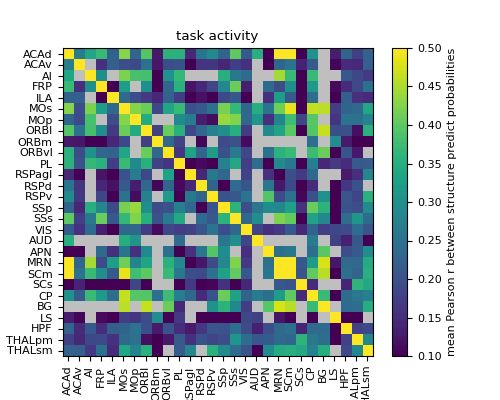

In [125]:
fig,ax=plt.subplots(1,1,figsize=(5,4))

masked_array = np.ma.array(corr_matrix_task_predict_proba, mask=np.isnan(corr_matrix_task_predict_proba))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

im=ax.imshow(np.abs(masked_array), aspect='auto', cmap=cmap, vmin=0.1, vmax=0.5, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
ax.set_xticks(np.arange(len(incl_structures)), incl_structures, rotation=90)
ax.set_yticks(np.arange(len(incl_structures)), incl_structures)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between structure predict probabilities')
ax.set_title('task activity')

Text(0.5, 1.0, 'spontaneous activity')

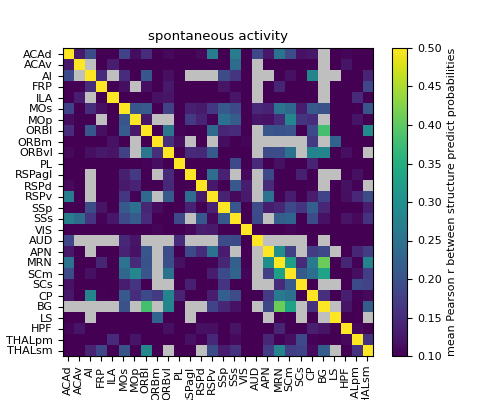

In [28]:
fig,ax=plt.subplots(1,1,figsize=(5,4))

masked_array = np.ma.array(corr_matrix_spont_predict_proba, mask=np.isnan(corr_matrix_spont_predict_proba))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

im=ax.imshow(np.abs(masked_array), aspect='auto', cmap=cmap, vmin=0.1, vmax=0.5, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
ax.set_xticks(np.arange(len(incl_structures)), incl_structures, rotation=90)
ax.set_yticks(np.arange(len(incl_structures)), incl_structures)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between structure predict probabilities')
ax.set_title('spontaneous activity')

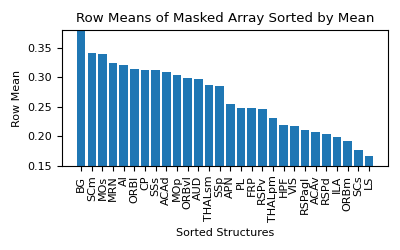

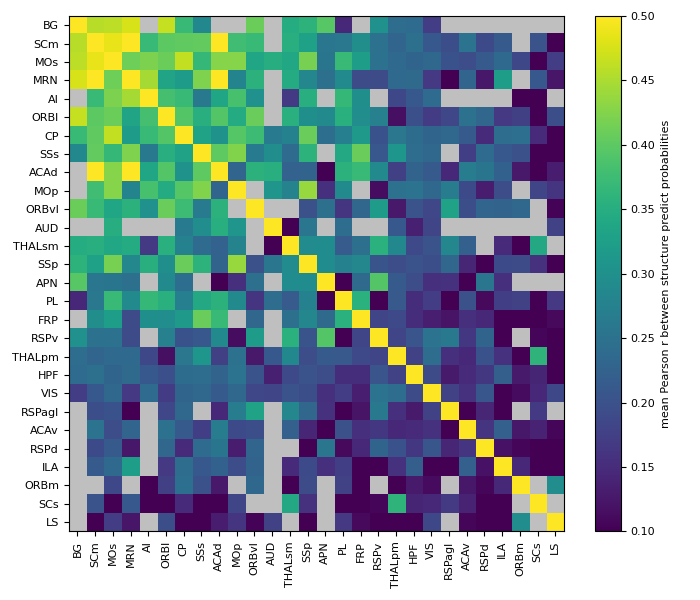

In [46]:
#sort by row mean
row_means = np.nanmean(corr_matrix_task_predict_proba, axis=1)
sort_idx = np.argsort(row_means)[::-1]
corr_matrix_sorted = corr_matrix_task_predict_proba[sort_idx][:,sort_idx]

masked_array_sorted = np.ma.array(corr_matrix_sorted, mask=np.isnan(corr_matrix_sorted))

labels_sorted = np.array(incl_structures)[sort_idx]

#plot row means
fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.bar(np.arange(len(row_means)), row_means[sort_idx])
ax.set_xticks(np.arange(len(incl_structures)), labels_sorted, rotation=90)
# ax.set_xticklabels(labels_sorted, rotation=90)
ax.set_xlabel('Sorted Structures')
ax.set_ylabel('Row Mean')
ax.set_ylim(0.15, 0.38)
ax.set_title('Row Means of Masked Array Sorted by Mean')
fig.tight_layout()


fig,ax=plt.subplots(1,1,figsize=(7,6))
im=ax.imshow(np.abs(masked_array_sorted), aspect='auto', cmap=cmap, vmin=0.1, vmax=0.5, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
ax.set_xticks(np.arange(len(incl_structures)), labels_sorted, rotation=90)
ax.set_yticks(np.arange(len(incl_structures)), labels_sorted)
#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between structure predict probabilities')
fig.tight_layout()

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15492\2172160997.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(1,1,figsize=(7,6))


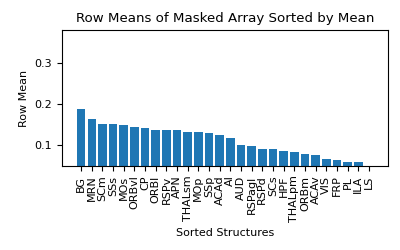

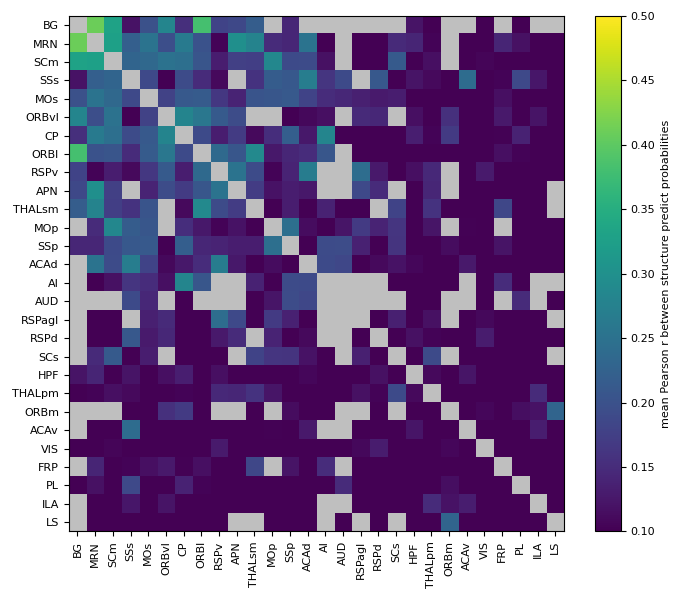

In [78]:
#sort by row mean
row_means = np.nanmean(corr_matrix_spont_predict_proba, axis=1)
sort_idx = np.argsort(row_means)[::-1]
corr_matrix_sorted = corr_matrix_spont_predict_proba[sort_idx][:,sort_idx]

masked_array_sorted = np.ma.array(corr_matrix_sorted, mask=np.isnan(corr_matrix_sorted))

labels_sorted = np.array(incl_structures)[sort_idx]

#plot row means
fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.bar(np.arange(len(row_means)), row_means[sort_idx])
ax.set_xticks(np.arange(len(incl_structures)), labels_sorted, rotation=90)
# ax.set_xticklabels(labels_sorted, rotation=90)
ax.set_xlabel('Sorted Structures')
ax.set_ylabel('Row Mean')
ax.set_ylim(0.05, 0.38)
ax.set_title('Row Means of Masked Array Sorted by Mean')
fig.tight_layout()


fig,ax=plt.subplots(1,1,figsize=(7,6))
im=ax.imshow(np.abs(masked_array_sorted), aspect='auto', cmap=cmap, vmin=0.1, vmax=0.5, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
ax.set_xticks(np.arange(len(incl_structures)), labels_sorted, rotation=90)
ax.set_yticks(np.arange(len(incl_structures)), labels_sorted)
#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between structure predict probabilities')
fig.tight_layout()

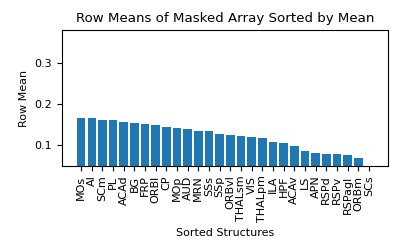

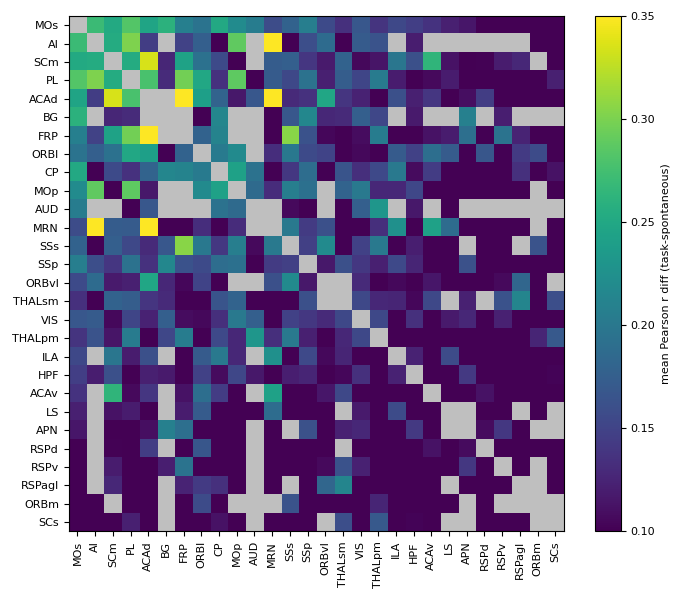

In [79]:
task_spont_diff=corr_matrix_task_predict_proba-corr_matrix_spont_predict_proba

#sort by row mean
row_means = np.nanmean(task_spont_diff, axis=1)
sort_idx = np.argsort(row_means)[::-1]
corr_matrix_sorted = task_spont_diff[sort_idx][:,sort_idx]

masked_array_sorted = np.ma.array(corr_matrix_sorted, mask=np.isnan(corr_matrix_sorted))

labels_sorted = np.array(incl_structures)[sort_idx]

#plot row means
fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.bar(np.arange(len(row_means)), row_means[sort_idx])
ax.set_xticks(np.arange(len(incl_structures)), labels_sorted, rotation=90)
# ax.set_xticklabels(labels_sorted, rotation=90)
ax.set_xlabel('Sorted Structures')
ax.set_ylabel('Row Mean')
ax.set_ylim(0.05, 0.38)
ax.set_title('Row Means of Masked Array Sorted by Mean')
fig.tight_layout()


fig,ax=plt.subplots(1,1,figsize=(7,6))
im=ax.imshow(np.abs(masked_array_sorted), aspect='auto', cmap=cmap, vmin=0.1, vmax=0.35, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
ax.set_xticks(np.arange(len(incl_structures)), labels_sorted, rotation=90)
ax.set_yticks(np.arange(len(incl_structures)), labels_sorted)
#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r diff (task-spontaneous)')
fig.tight_layout()

In [201]:
# scipy method, probably not as good
# corr_matrix=corr_matrix_task_predict_proba.copy()
# naninds=np.isnan(corr_matrix)
# corr_matrix[naninds]=np.nanmedian(corr_matrix)

# #hierarchical clustering
# import scipy.cluster.hierarchy as sch
# import scipy.spatial.distance as ssd
# pairwise_distances = ssd.pdist(corr_matrix)
# linkage = sch.linkage(pairwise_distances, method='complete')
# cluster_distance_threshold = pairwise_distances.max()*0.9
# idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
#                                     criterion='distance')
# idx = np.argsort(idx_to_cluster_array)
# idx

In [ ]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

    return linkage_matrix

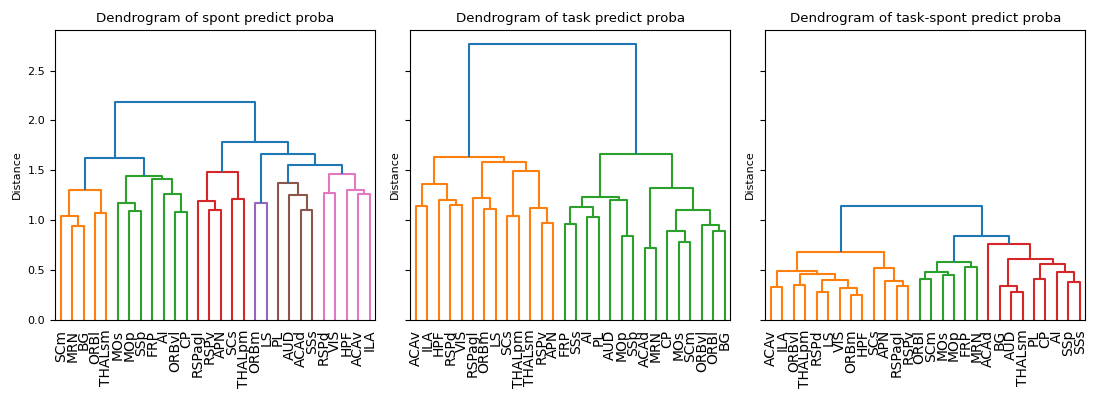

In [ ]:
from sklearn.cluster import AgglomerativeClustering

sort_idx={}
use_epochs=['spont','task','task-spont']

fig,ax=plt.subplots(1,3,figsize=(11,4),sharey=True)

ax_max=[]

for ee, epoch in enumerate(use_epochs):
    if epoch=='task':
        corr_matrix=corr_matrix_task_predict_proba.copy()
    elif epoch=='spont':
        corr_matrix=corr_matrix_spont_predict_proba.copy()
    elif epoch=='task-spont':
        corr_matrix=corr_matrix_task_predict_proba.copy()-corr_matrix_spont_predict_proba.copy()

     #hierarchical clustering
    clustering = AgglomerativeClustering(
        n_clusters=2,
        metric='euclidean',
        linkage='ward',
        compute_distances=True,
    )

    naninds=np.isnan(corr_matrix)
    corr_matrix[naninds]=np.nanmedian(corr_matrix[corr_matrix!=1])
    clustering.fit(corr_matrix)

    idx = np.argsort(clustering.labels_)

    sort_idx[epoch] = idx

    linkage_matrix=plot_dendrogram(clustering,labels=incl_structures,ax=ax[ee])#, truncate_mode="level", p=3)
    ax[ee].set_ylabel('Distance')
    ax[ee].set_title(f'Dendrogram of {epoch} predict proba')
    ax[ee].tick_params(axis='x', rotation=90)

    ax_max.append(np.diff(ax[ee].get_ylim()))

#set ylim to max of any axis
ax[0].set_ylim(0,np.max(ax_max))

fig.tight_layout()

In [ ]:
# linkage_matrix

30

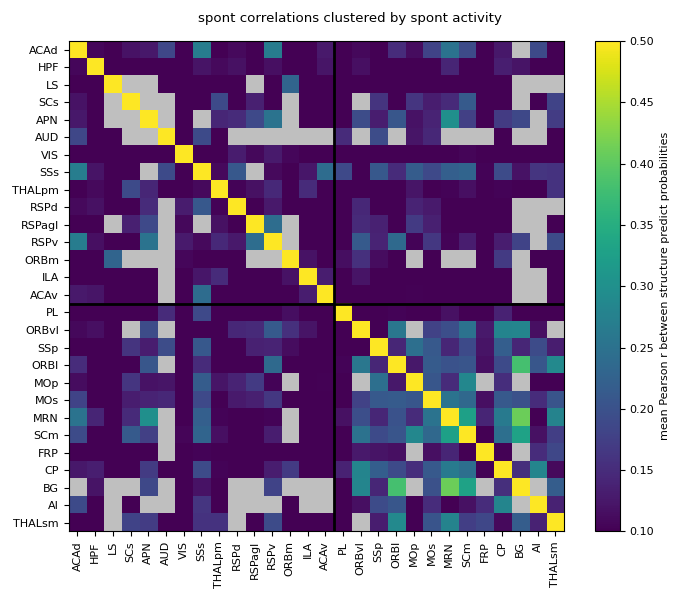

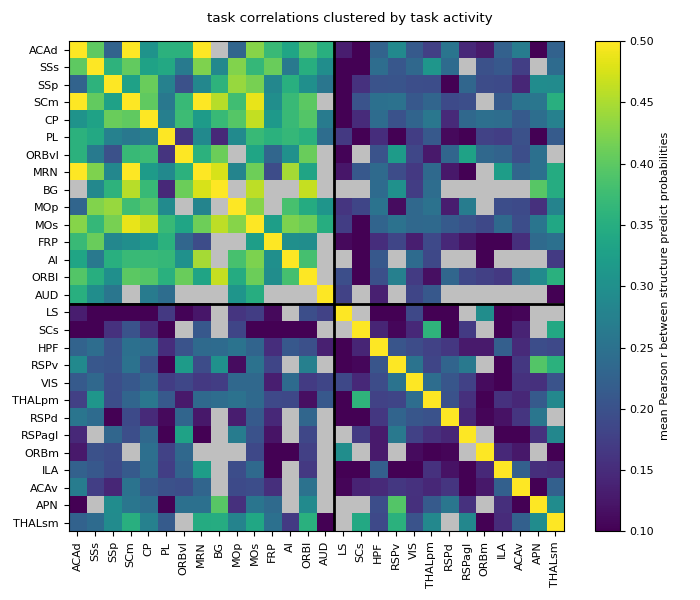

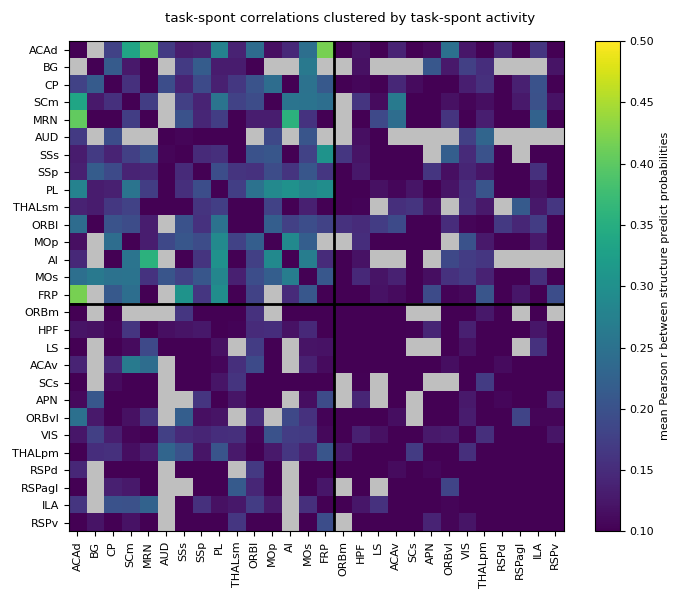

In [288]:

sortby=None #'task','spont','task-spont', or None

for ee, epoch in enumerate(use_epochs):
    if epoch=='task':
        corr_matrix=corr_matrix_task_predict_proba.copy()
        cmap = matplotlib.cm.viridis
        vmin=0.1
        vmax=0.5
    elif epoch=='spont':
        corr_matrix=corr_matrix_spont_predict_proba.copy()
        cmap = matplotlib.cm.viridis
        vmin=0.1
        vmax=0.5
    elif epoch=='task-spont':
        corr_matrix=corr_matrix_task_predict_proba.copy()-corr_matrix_spont_predict_proba.copy()
        # cmap = matplotlib.cm.bwr
        # vmin=-0.2
        # vmax=0.2
        cmap = matplotlib.cm.viridis
        vmin=0.1
        vmax=0.5

    if sortby is not None:
        sel_sort_idx=sort_idx[sortby]
        sort_str=sortby
    else:
        sel_sort_idx=sort_idx[epoch]
        sort_str=epoch

    masked_array = np.ma.array(corr_matrix, mask=np.isnan(corr_matrix))
    
    cmap.set_bad('grey',0.5)

    fig,ax=plt.subplots(1,1,figsize=(7,6))
    im=ax.imshow(np.abs(masked_array[sel_sort_idx][:,sel_sort_idx]), aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
    ax.set_xticks(np.arange(len(incl_structures)), np.array(incl_structures)[sel_sort_idx], rotation=90)
    ax.set_yticks(np.arange(len(incl_structures)), np.array(incl_structures)[sel_sort_idx])

    cluster_borders = np.where(np.diff(np.sort(clustering.labels_)) != 0)[0] + 0.5

    for xx in cluster_borders:
        ax.axvline(x=xx, color='black', linestyle='-', linewidth=2)
        ax.axhline(y=xx, color='black', linestyle='-', linewidth=2)

    #colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('mean Pearson r between structure predict probabilities')
    fig.suptitle(f'{epoch} correlations clustered by {sort_str} activity')
    fig.tight_layout()


In [ ]:
#find "default" state of network


#average predict proba from each area in spontaneous blocks prior to task (plus after task)


#if bias aligns to actual starting block, do they perform better?



In [ ]:
structure_table=new_predict_proba_pd.query('structure=="MOs"').iloc[0]

structure_table['predict_proba_spont'][structure_table['spont_is_pre_task']].mean()


0.607707102213743

In [216]:
row['predict_proba_spont'].shape
row['spont_is_pre_task'].shape

NameError: name 'row' is not defined

In [245]:
mean_pre_task=[]
mean_post_task=[]
for rr,row in new_predict_proba_pd.iterrows():
    if len(row['spont_is_pre_task'])>len(row['predict_proba_spont']):
        spont_is_pre_task=row['spont_is_pre_task'][:len(row['predict_proba_spont'])]
    else:
        spont_is_pre_task=row['spont_is_pre_task']
    mean_pre_task.append(row['predict_proba_spont'][spont_is_pre_task].mean())
    mean_post_task.append(row['predict_proba_spont'][~spont_is_pre_task].mean())

new_predict_proba_pd['mean_pre_task']=mean_pre_task
new_predict_proba_pd['mean_post_task']=mean_post_task

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_18152\154321808.py:9: RuntimeWarning: Mean of empty slice.
  mean_post_task.append(row['predict_proba_spont'][~spont_is_pre_task].mean())
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


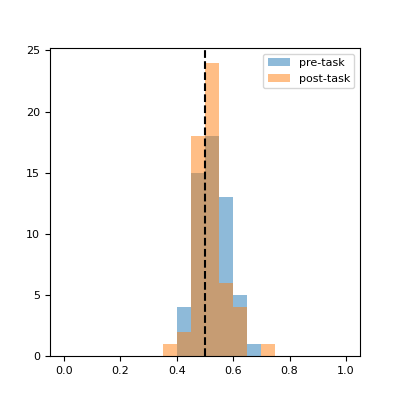

In [246]:
sel_structure='HPF'

xbins=np.arange(0,1.01,0.05)

fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.axvline(0.5, color='k', linestyle='--')
ax.hist(new_predict_proba_pd.query(f'structure=="{sel_structure}"')['mean_pre_task'], bins=xbins, alpha=0.5, label='pre-task')
ax.hist(new_predict_proba_pd.query(f'structure=="{sel_structure}"')['mean_post_task'], bins=xbins, alpha=0.5, label='post-task')
ax.legend()

In [247]:
# new_predict_proba_pd.query('structure=="HPF"')

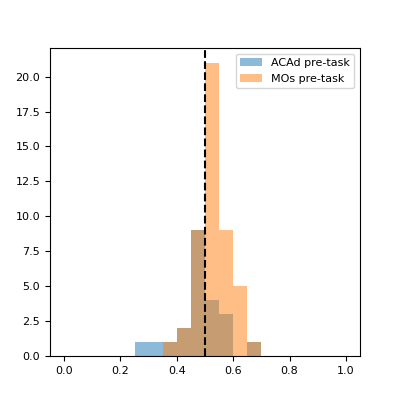

In [269]:
sel_structure_1='ACAd'
sel_structure_2='MOs'

xbins=np.arange(0,1.01,0.05)

fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.axvline(0.5, color='k', linestyle='--')
ax.hist(new_predict_proba_pd.query(f'structure=="{sel_structure_1}"')['mean_pre_task'], bins=xbins, alpha=0.5, label=sel_structure_1+' pre-task')
ax.hist(new_predict_proba_pd.query(f'structure=="{sel_structure_2}"')['mean_pre_task'], bins=xbins, alpha=0.5, label=sel_structure_2+' pre-task')
ax.legend()

In [277]:
struct1='ORBl'
struct2='VIS'

stats.wilcoxon(new_predict_proba_pd.query(f'structure=="{struct1}"')['mean_pre_task']-0.5)
stats.wilcoxon(new_predict_proba_pd.query(f'structure=="{struct2}"')['mean_pre_task']-0.5)

WilcoxonResult(statistic=384.0, pvalue=0.2883951598762451)

In [265]:
# new_predict_proba_pd.query(f'structure=="{struct1}"')['mean_pre_task']

In [221]:
struct1='MRN'
struct2='SCm'

s1=new_predict_proba_pd.query(f'session_id=="667252_2023-09-26" and structure=="{struct1}"')
s2=new_predict_proba_pd.query(f'session_id=="667252_2023-09-26" and structure=="{struct2}"')

s1['predict_proba_spont'].values[0][s1['spont_is_pre_task'].values[0]].mean()
s2['predict_proba_spont'].values[0][s2['spont_is_pre_task'].values[0]].mean()

0.5595063048270132

In [ ]:
stats.wilcoxon(s1['predict_proba_spont'].values[0][s1['spont_is_pre_task'].values[0]]-0.5)

WilcoxonResult(statistic=4065.0, pvalue=8.033828646292382e-10)

In [61]:
s1['predict_proba_spont'].values[0]

array([0.38427588, 0.5997829 , 0.34489107, 0.27521368, 0.37766428,
       0.20678216, 0.37164398, 0.42980149, 0.2612155 , 0.5326564 ,
       0.33365314, 0.46560207, 0.23187411, 0.13817884, 0.19518865,
       0.54288903, 0.65091161, 0.56626775, 0.10458794, 0.30981059,
       0.43744695, 0.28445719, 0.07473858, 0.09177391, 0.49051552,
       0.57011783, 0.31321222, 0.25236477, 0.39523703, 0.41664481,
       0.32006937, 0.45090647, 0.27218289, 0.53128923, 0.4268461 ,
       0.550833  , 0.67325199, 0.70210501, 0.21306611, 0.27590664,
       0.41478222, 0.32569098, 0.23582138, 0.5388399 , 0.18941429,
       0.31347288, 0.45385776, 0.21926722, 0.22282331, 0.39457583,
       0.60526662, 0.16310346, 0.3321446 , 0.23418894, 0.812542  ,
       0.64437315, 0.37280031, 0.30346317, 0.68352645, 0.72285081,
       0.3717655 , 0.52055722, 0.1925413 , 0.36354534, 0.37381521,
       0.5116138 , 0.3822202 , 0.57086187, 0.28580017, 0.68769207,
       0.28964747, 0.16521793, 0.54022721, 0.47574547, 0.27253

In [ ]:
#for each structure, find if pre or post task spontaneous is significantly different from 0.5



In [291]:
face_decoding_loo = pl.read_parquet('s3://aind-scratch-data/dynamic-routing/face-decoding-loo/results/v268_6/')
face_decoding_loo

balanced_accuracy_test,balanced_accuracy_train,time_aligned_to,bin_size,bin_center,shift_idx,repeat_idx,excluded_subject_id,train_session_ids,test_session_ids,predict_proba,coefs,is_all_trials,is_templeton,model_label
f64,f64,enum,f64,f64,i16,u16,i64,list[str],list[str],list[f64],list[f64],bool,bool,str
0.49178,0.502484,"""quiescent_stop_time""",1.5,-0.75,null,0,620263,"[""620264_2022-08-02"", ""620264_2022-08-02"", … ""670180_2023-07-27""]","[""620263_2022-07-26"", ""620263_2022-07-26"", … ""620263_2022-07-27""]","[0.518102, 0.509134, … 0.501137]",[-0.038272],true,true,"""ear"""
0.470211,0.50572,"""quiescent_stop_time""",1.5,-0.75,null,0,620264,"[""620263_2022-07-26"", ""620263_2022-07-26"", … ""670180_2023-07-27""]","[""620264_2022-08-02"", ""620264_2022-08-02"", … ""620264_2022-08-02""]","[0.500332, 0.500304, … 0.50267]",[-0.009458],true,true,"""ear"""
0.470222,0.503352,"""quiescent_stop_time""",1.5,-0.75,null,0,636397,"[""620263_2022-07-26"", ""620263_2022-07-26"", … ""670180_2023-07-27""]","[""636397_2022-09-26"", ""636397_2022-09-26"", … ""636397_2022-09-26""]","[0.501373, 0.500934, … 0.499769]",[-0.033323],true,true,"""ear"""
0.487626,0.50354,"""quiescent_stop_time""",1.5,-0.75,null,0,646318,"[""620263_2022-07-26"", ""620263_2022-07-26"", … ""670180_2023-07-27""]","[""646318_2023-01-17"", ""646318_2023-01-17"", … ""646318_2023-01-18""]","[0.500931, 0.490578, … 0.518403]",[-0.031498],true,true,"""ear"""
0.465636,0.507876,"""quiescent_stop_time""",1.5,-0.75,null,0,649944,"[""620263_2022-07-26"", ""620263_2022-07-26"", … ""670180_2023-07-27""]","[""649944_2023-02-27"", ""649944_2023-02-27"", … ""649944_2023-02-28""]","[0.505745, 0.497056, … 0.493893]",[-0.041978],true,true,"""ear"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.579633,0.519406,"""quiescent_stop_time""",1.5,-0.75,null,0,636397,"[""620263_2022-07-26"", ""620263_2022-07-26"", … ""670180_2023-07-27""]","[""636397_2022-09-26"", ""636397_2022-09-26"", … ""636397_2022-09-26""]","[0.483744, 0.498302, … 0.424377]",[-0.137519],true,true,"""nose"""
0.511495,0.526499,"""quiescent_stop_time""",1.5,-0.75,null,0,646318,"[""620263_2022-07-26"", ""620263_2022-07-26"", … ""670180_2023-07-27""]","[""646318_2023-01-17"", ""646318_2023-01-17"", … ""646318_2023-01-18""]","[0.477115, 0.478022, … 0.495612]",[-0.102748],true,true,"""nose"""
0.523701,0.524498,"""quiescent_stop_time""",1.5,-0.75,null,0,649944,"[""620263_2022-07-26"", ""620263_2022-07-26"", … ""670180_2023-07-27""]","[""649944_2023-02-27"", ""649944_2023-02-27"", … ""649944_2023-02-28""]","[0.519712, 0.512083, … 0.453949]",[-0.112614],true,true,"""nose"""


In [ ]:
face_decoding = pl.read_parquet('s3://aind-scratch-data/dynamic-routing/face-decoding/results/v268_3/')
face_decoding #= face_decoding.filter(pl.col('time_aligned_to').eq('quiescent_stop_time'))

balanced_accuracy_test,balanced_accuracy_train,time_aligned_to,bin_size,bin_center,shift_idx,repeat_idx,predict_proba,trial_indices,coefs,is_all_trials,session_id,model_label
f64,f64,enum,f64,f64,i16,u16,list[f64],list[u16],list[f64],bool,str,str
0.548348,0.551388,"""quiescent_stop_time""",1.5,-0.75,-46,0,null,null,"[0.162915, -0.364303, … -0.408624]",false,"""644867_2023-02-20""","""facial_features"""
0.528465,0.561412,"""quiescent_stop_time""",1.5,-0.75,-45,0,null,null,"[0.166952, -0.603603, … -0.396253]",false,"""644867_2023-02-20""","""facial_features"""
0.551176,0.562035,"""quiescent_stop_time""",1.5,-0.75,-44,0,null,null,"[0.165875, -0.690519, … -0.367309]",false,"""644867_2023-02-20""","""facial_features"""
0.520737,0.524862,"""quiescent_stop_time""",1.5,-0.75,-43,0,null,null,"[0.042182, -0.083542, … -0.087161]",false,"""644867_2023-02-20""","""facial_features"""
0.557128,0.577701,"""quiescent_stop_time""",1.5,-0.75,-42,0,null,null,"[0.126109, -0.853481, … -0.327767]",false,"""644867_2023-02-20""","""facial_features"""
…,…,…,…,…,…,…,…,…,…,…,…,…
0.51204,0.518187,"""response_time""",0.25,6.875,4,0,null,null,[0.010286],false,"""662983_2023-05-16""","""jaw"""
0.505583,0.517102,"""response_time""",0.25,6.875,5,0,null,null,[0.042411],false,"""662983_2023-05-16""","""jaw"""
0.469592,0.526543,"""response_time""",0.25,6.875,6,0,null,null,[0.006732],false,"""662983_2023-05-16""","""jaw"""


In [293]:
face_decoding['model_label'].unique()

model_label
str
"""jaw"""
"""whisker_pad"""
"""nose"""
"""ear"""
"""facial_features"""
"""facemap"""


In [294]:
face_decoding['time_aligned_to'].unique()

time_aligned_to
enum
"""quiescent_stop_time"""
"""stim_start_time"""
"""response_time"""


In [304]:
face_decoding.filter(
    pl.col('time_aligned_to').eq('stim_start_time'),
    pl.col('model_label').eq('facial_features'),
    pl.col('is_all_trials'),
    pl.col('bin_center').eq(-0.375)
    )

balanced_accuracy_test,balanced_accuracy_train,time_aligned_to,bin_size,bin_center,shift_idx,repeat_idx,predict_proba,trial_indices,coefs,is_all_trials,session_id,model_label
f64,f64,enum,f64,f64,i16,u16,list[f64],list[u16],list[f64],bool,str,str
0.821063,0.834823,"""stim_start_time""",0.25,-0.375,null,0,"[0.62268, 0.249095, … 0.089352]","[0, 1, … 533]","[-0.958159, -2.225017, … 1.318978]",true,"""644867_2023-02-20""","""facial_features"""
0.734739,0.738088,"""stim_start_time""",0.25,-0.375,null,0,"[0.380417, 0.402883, … 0.424074]","[0, 1, … 526]","[0.120226, -0.135198, … 0.375636]",true,"""750329_2024-11-27""","""facial_features"""
0.64304,0.653579,"""stim_start_time""",0.25,-0.375,null,0,"[0.568461, 0.329684, … 0.725451]","[0, 1, … 507]","[0.448281, -0.060578, … 0.163588]",true,"""708016_2024-05-01""","""facial_features"""
0.716038,0.715797,"""stim_start_time""",0.25,-0.375,null,0,"[0.487145, 0.254051, … 0.640207]","[0, 1, … 515]","[-0.325762, -0.565716, … -0.053038]",true,"""674562_2023-10-05""","""facial_features"""
0.774,0.777918,"""stim_start_time""",0.25,-0.375,null,0,"[0.79525, 0.805971, … 0.332414]","[0, 1, … 469]","[-0.091962, -0.320345, … -0.313733]",true,"""690706_2023-11-29""","""facial_features"""
…,…,…,…,…,…,…,…,…,…,…,…,…
0.701898,0.712713,"""stim_start_time""",0.25,-0.375,null,0,"[0.483845, 0.682599, … 0.161755]","[0, 1, … 529]","[-0.528055, -0.080328, … -0.380508]",true,"""686740_2023-10-25""","""facial_features"""
0.812254,0.810513,"""stim_start_time""",0.25,-0.375,null,0,"[0.382444, 0.356321, … 0.255304]","[0, 1, … 496]","[-0.482231, 0.644798, … 1.007052]",true,"""690706_2023-11-28""","""facial_features"""
0.696734,0.707124,"""stim_start_time""",0.25,-0.375,null,0,"[0.571533, 0.334293, … 0.373884]","[0, 1, … 546]","[0.683652, -0.657206, … 0.571674]",true,"""649943_2023-02-15""","""facial_features"""


In [312]:
all_trials.columns

Index(['start_time', 'stop_time', 'quiescent_start_time',
       'quiescent_stop_time', 'stim_start_time', 'stim_stop_time',
       'response_window_start_time', 'response_window_stop_time',
       'task_control_response_time', 'response_time', 'reward_time',
       'post_response_window_start_time', 'post_response_window_stop_time',
       'stim_name', 'block_index', 'rewarded_modality', 'trial_index',
       'trial_index_in_block', 'repeat_index', 'is_response', 'is_correct',
       'is_incorrect', 'is_hit', 'is_false_alarm', 'is_correct_reject',
       'is_miss', 'is_go', 'is_nogo', 'is_rewarded', 'is_noncontingent_reward',
       'is_contingent_reward', 'is_reward_scheduled', 'is_instruction',
       'is_aud_stim', 'is_vis_stim', 'is_catch', 'is_target', 'is_aud_target',
       'is_vis_target', 'is_nontarget', 'is_aud_nontarget', 'is_vis_nontarget',
       'is_vis_rewarded', 'is_aud_rewarded', 'is_block_switch', 'is_repeat',
       'is_opto', 'is_task_control_correct', 'session_idx